I need to fill the functions that I just used from the other files, create text explaining how to use the models, create the if statements for running the simulations or just plotting results from saved data. I think this may take 3 to 4 days, specially the explanation texts. After finishing this, I need to do a run of everything to make sure it works well. And them delete everything that it is not in this file, and put the dissertation original and the corrected version after I finishe subbitting the corrected version to the library with the links also for completeness of the repo, also put everything on zenodo and on github properly and with open code.

 # Imports

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy as scp
from tqdm.auto import tqdm
from functools import partial
from IPython.display import display
from fractions import Fraction
from core.utils import *
from core.models import *
from core.plot_funcs import *

# Utils

## Visuals of the plots

In [ ]:
default_area=mpl.rcParams['figure.figsize'][0]*mpl.rcParams['figure.figsize'][1]
new_figsize=[14,8]
mpl.rcParams['figure.figsize'] = new_figsize
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['ytick.minor.visible']=True
mpl.rcParams['axes.grid']=True
mpl.rc('xtick', labelsize=18)           # x-tick numbers only
mpl.rc('ytick', labelsize=18)           # y-tick numbers only
mpl.rcParams['figure.dpi']=300

# Energy Levels and States

## Models 2 & 3 No-HF

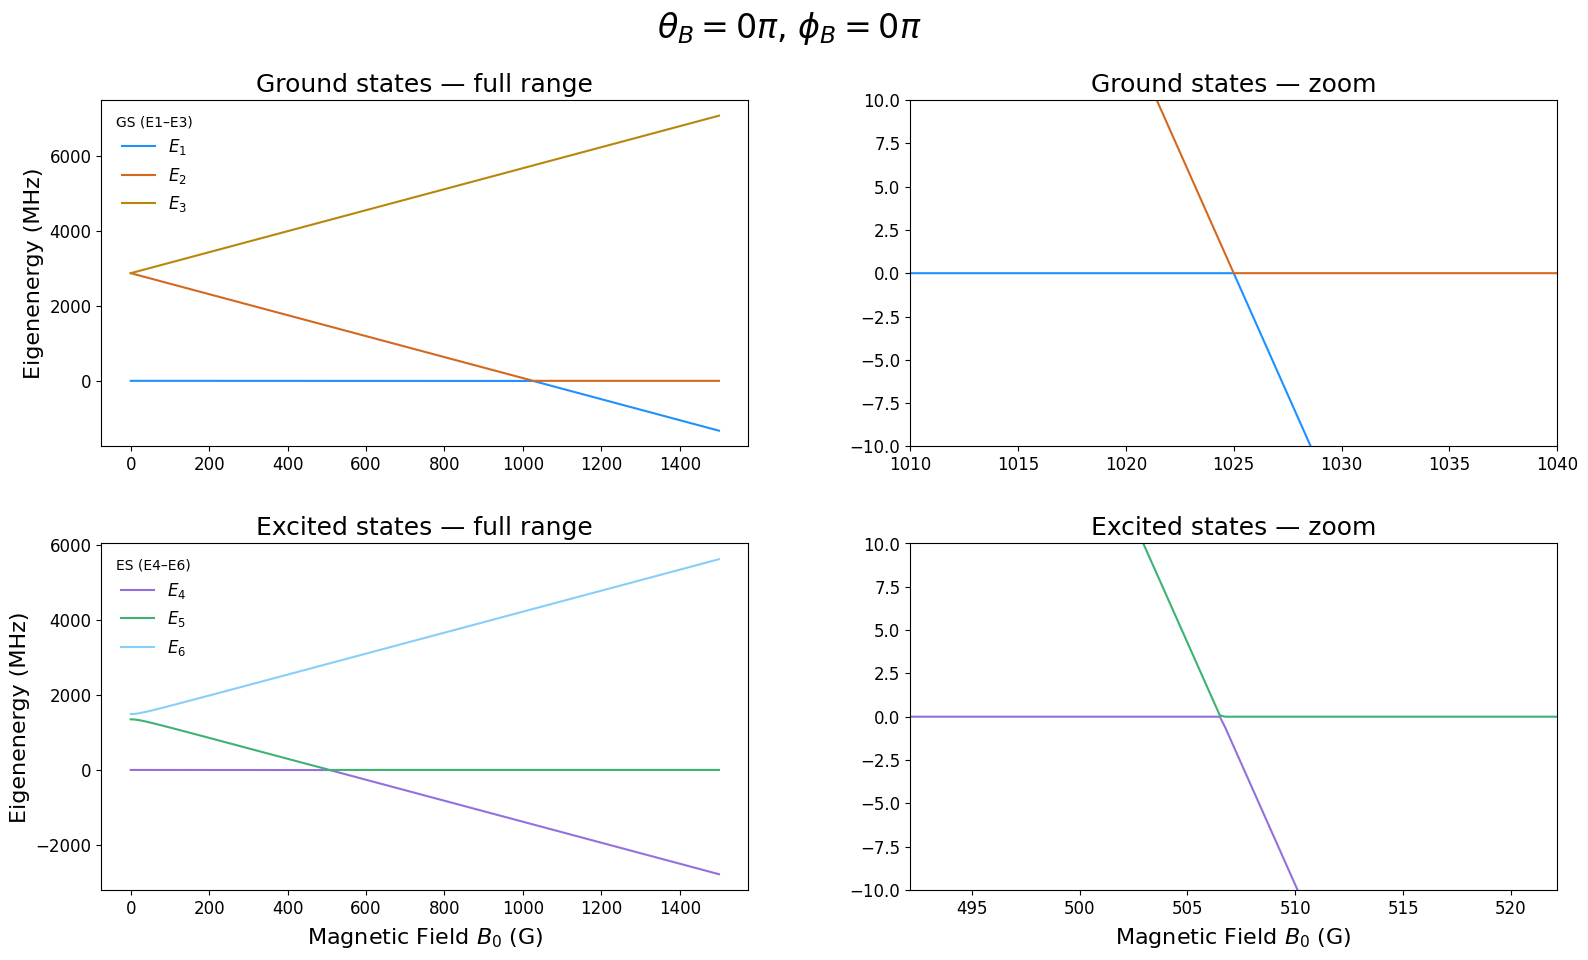

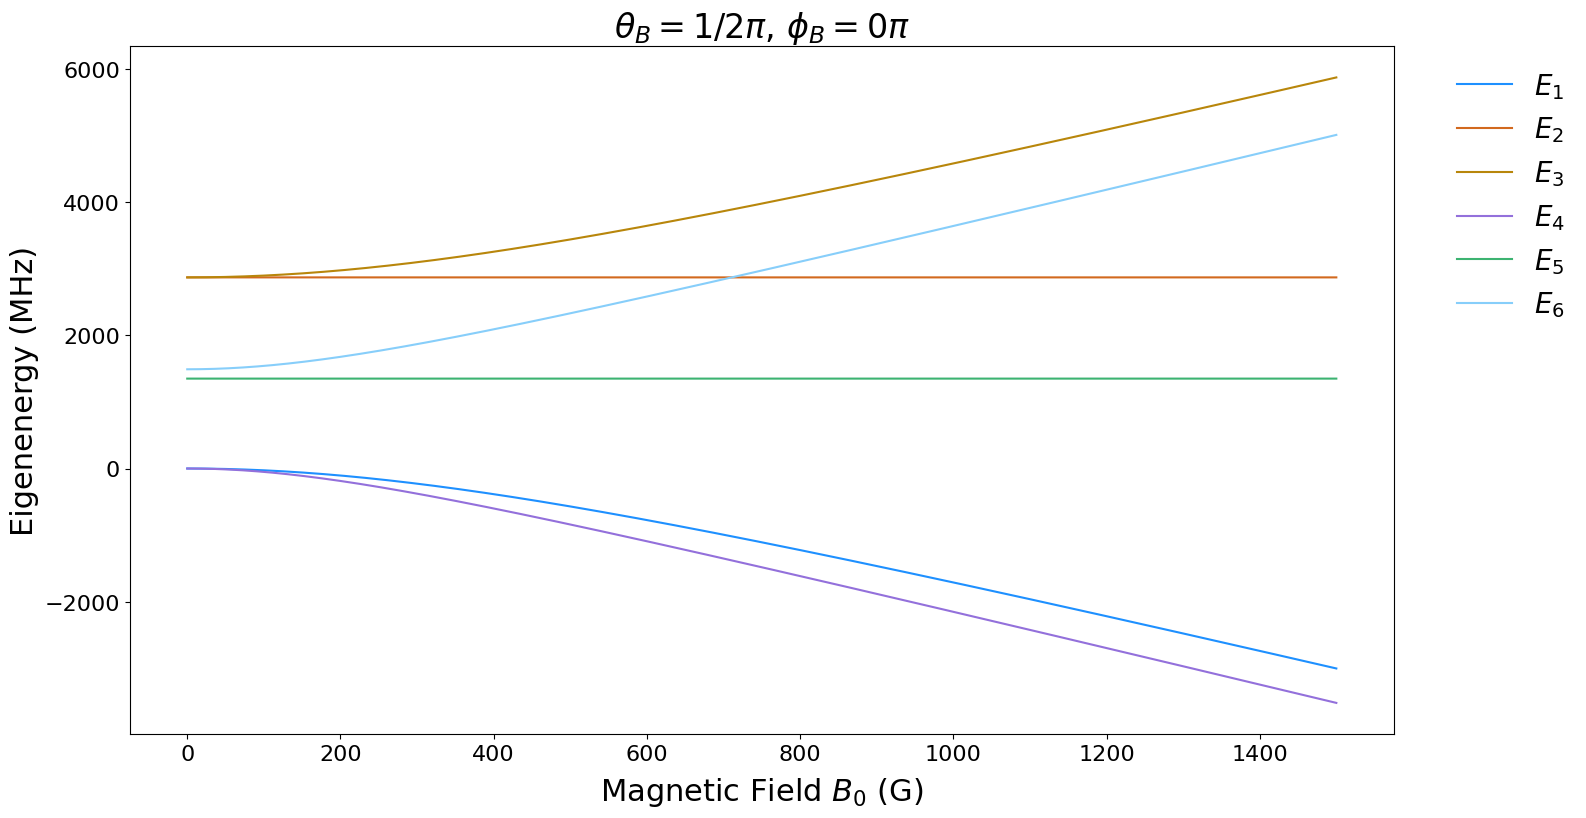

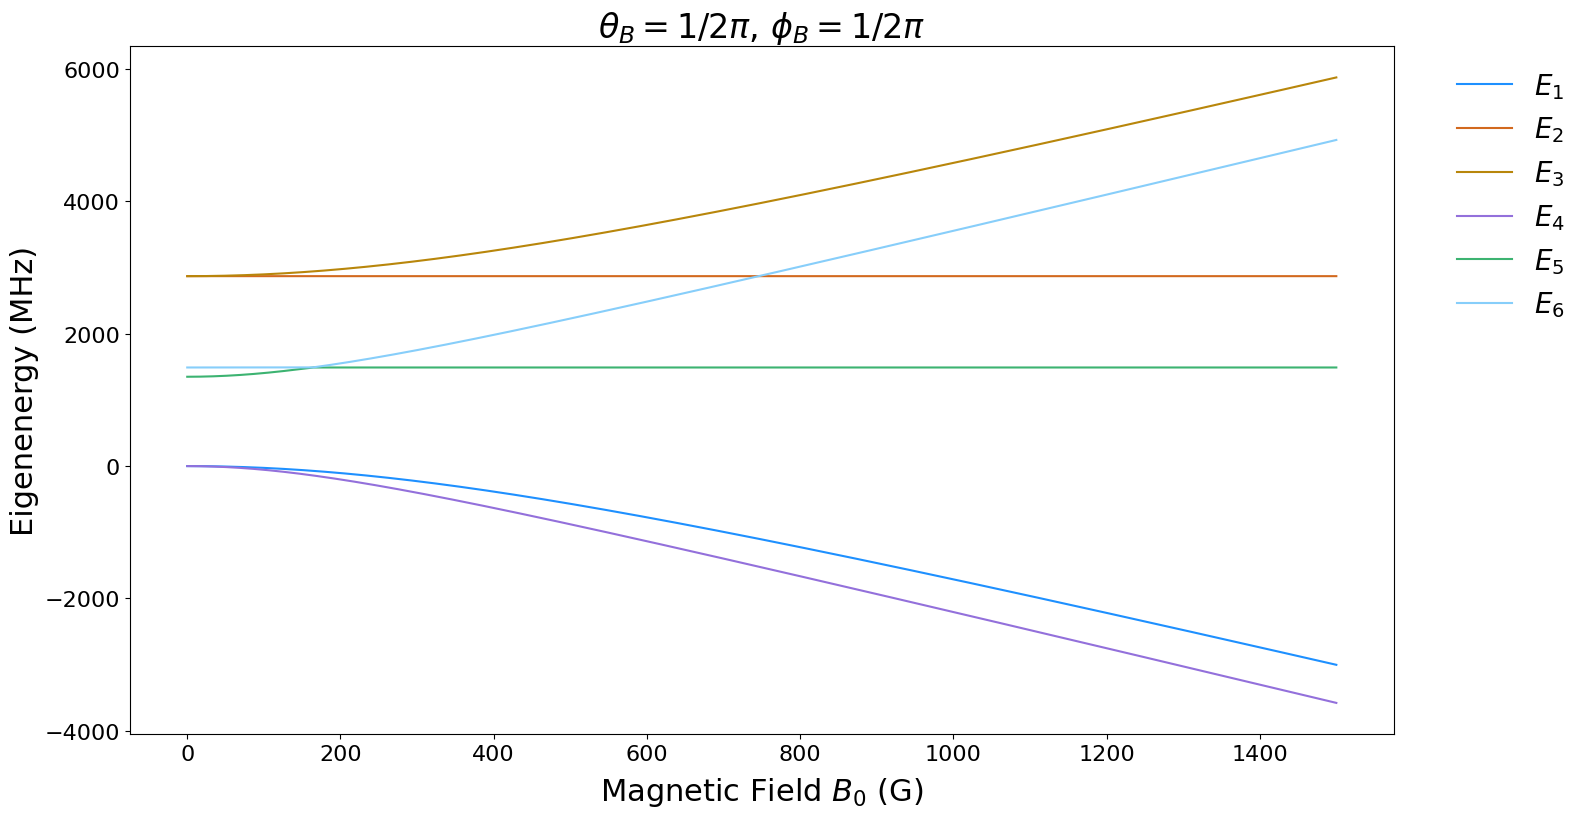

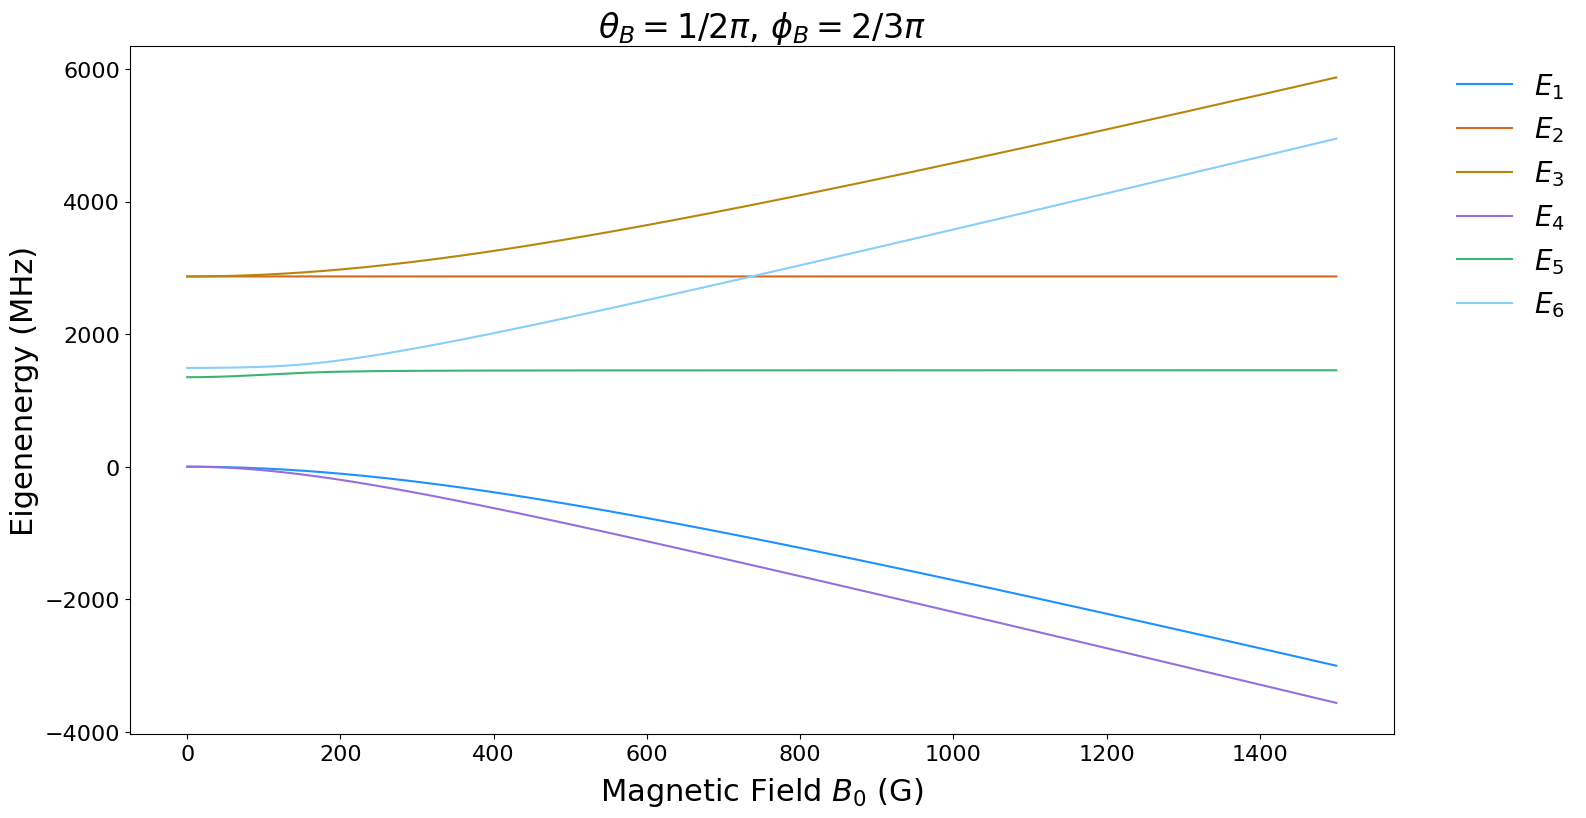

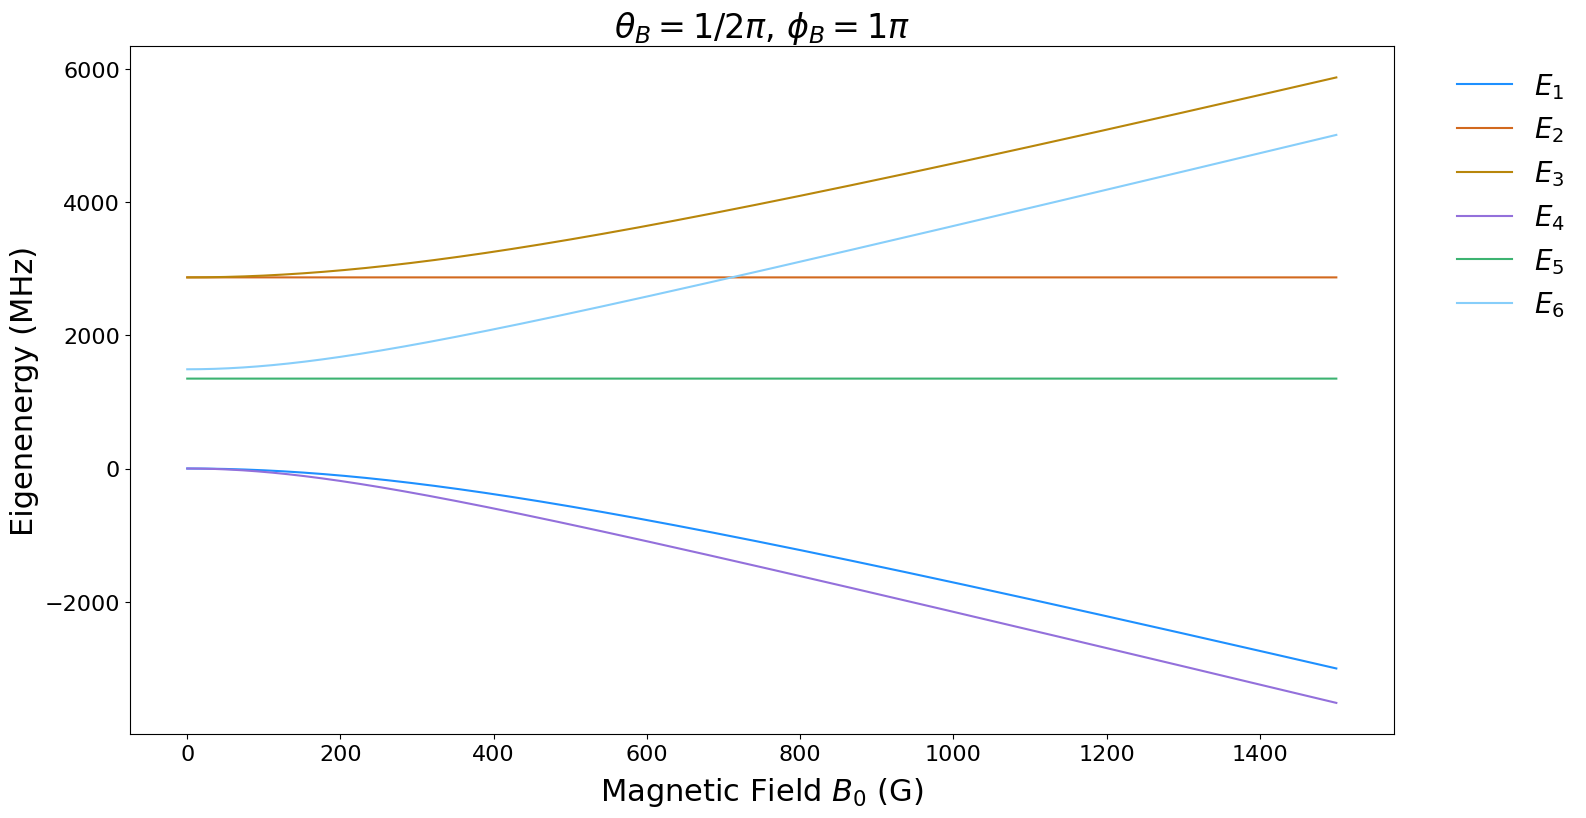

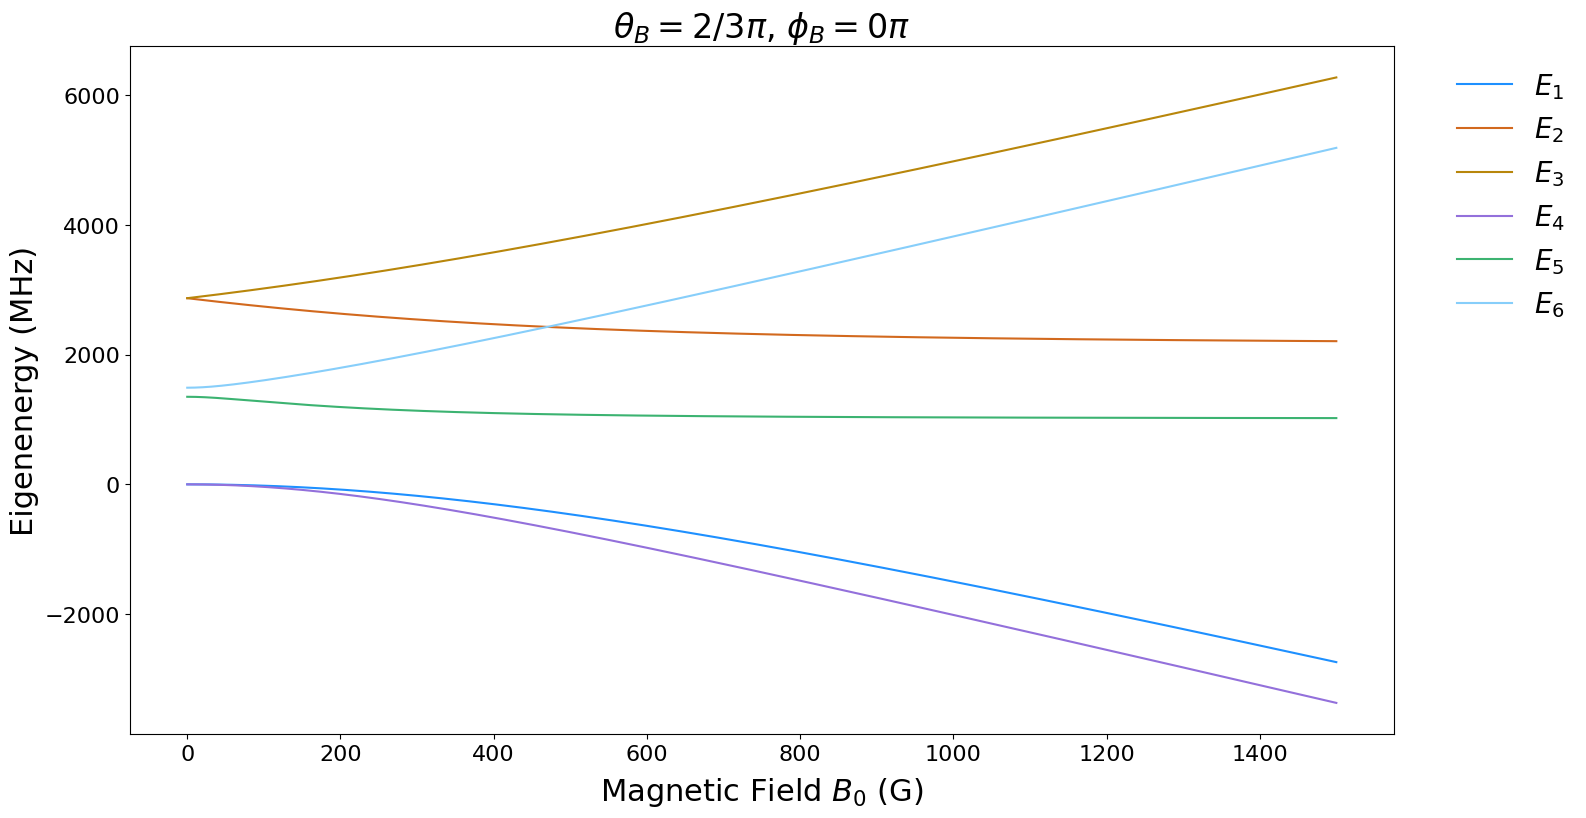

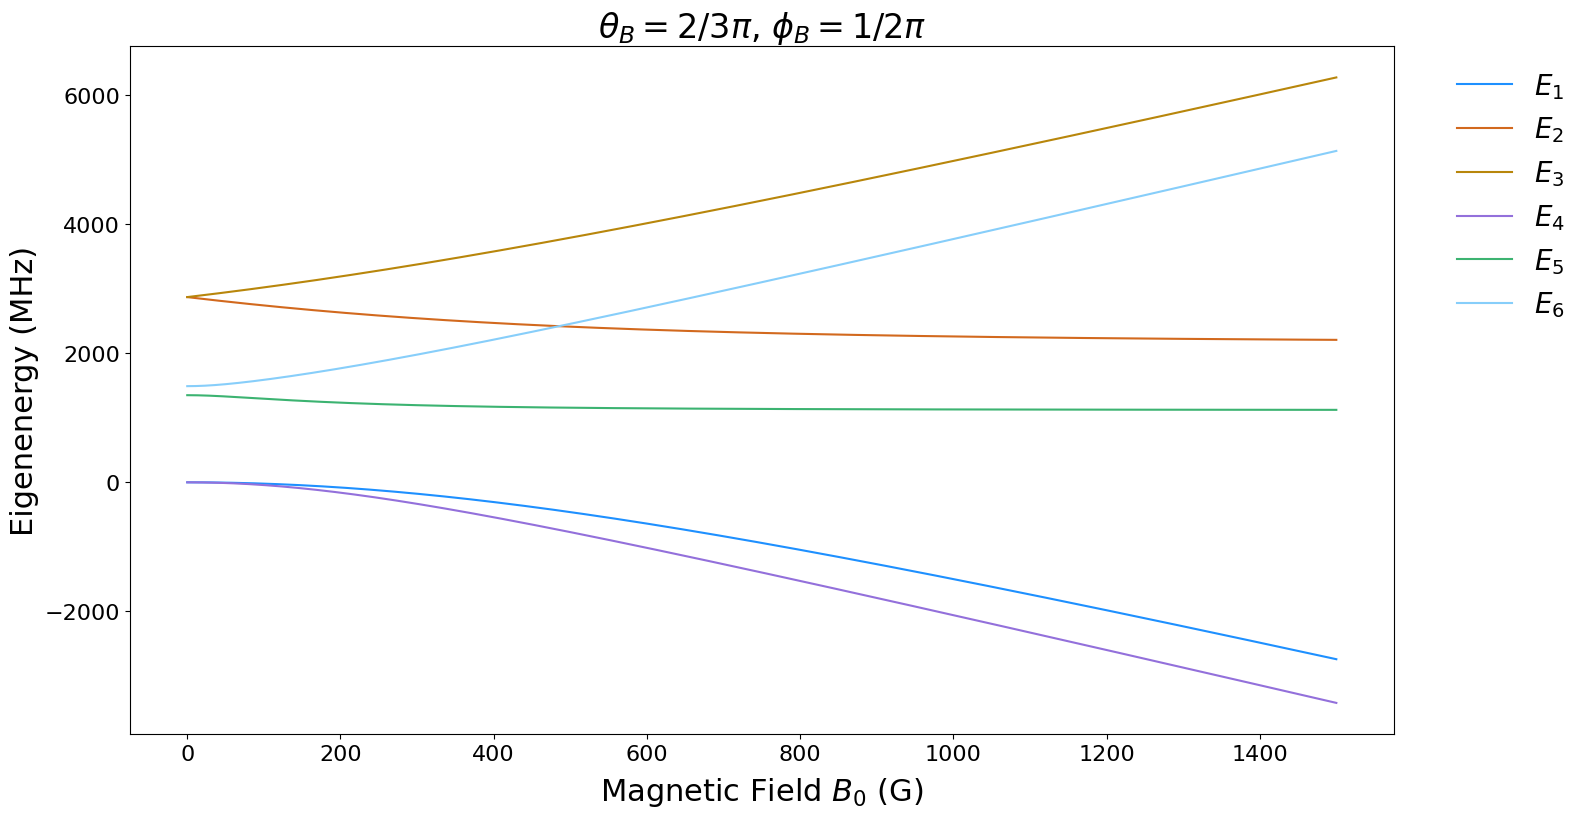

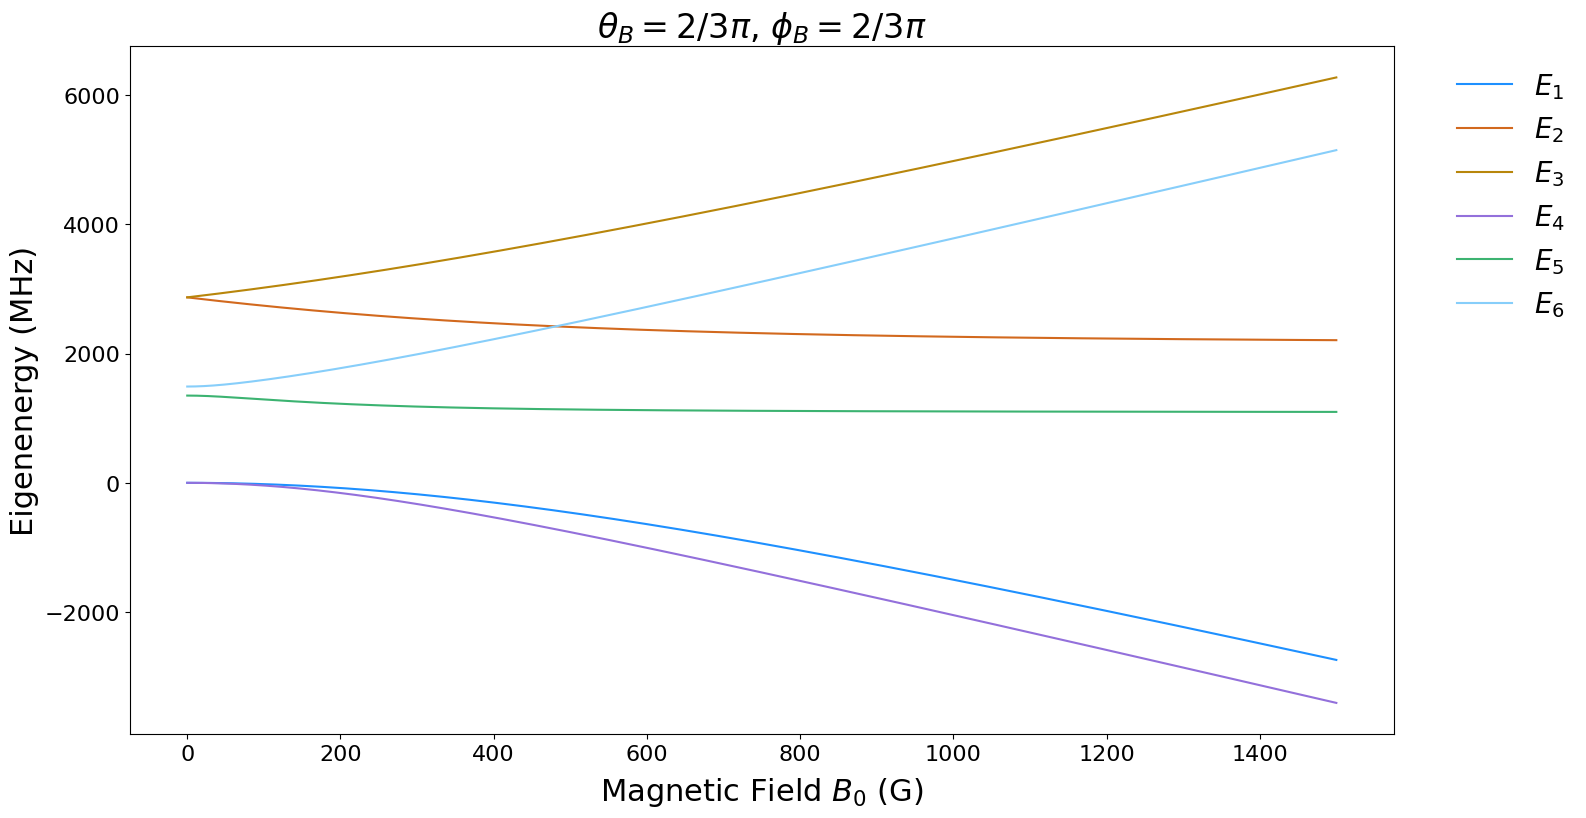

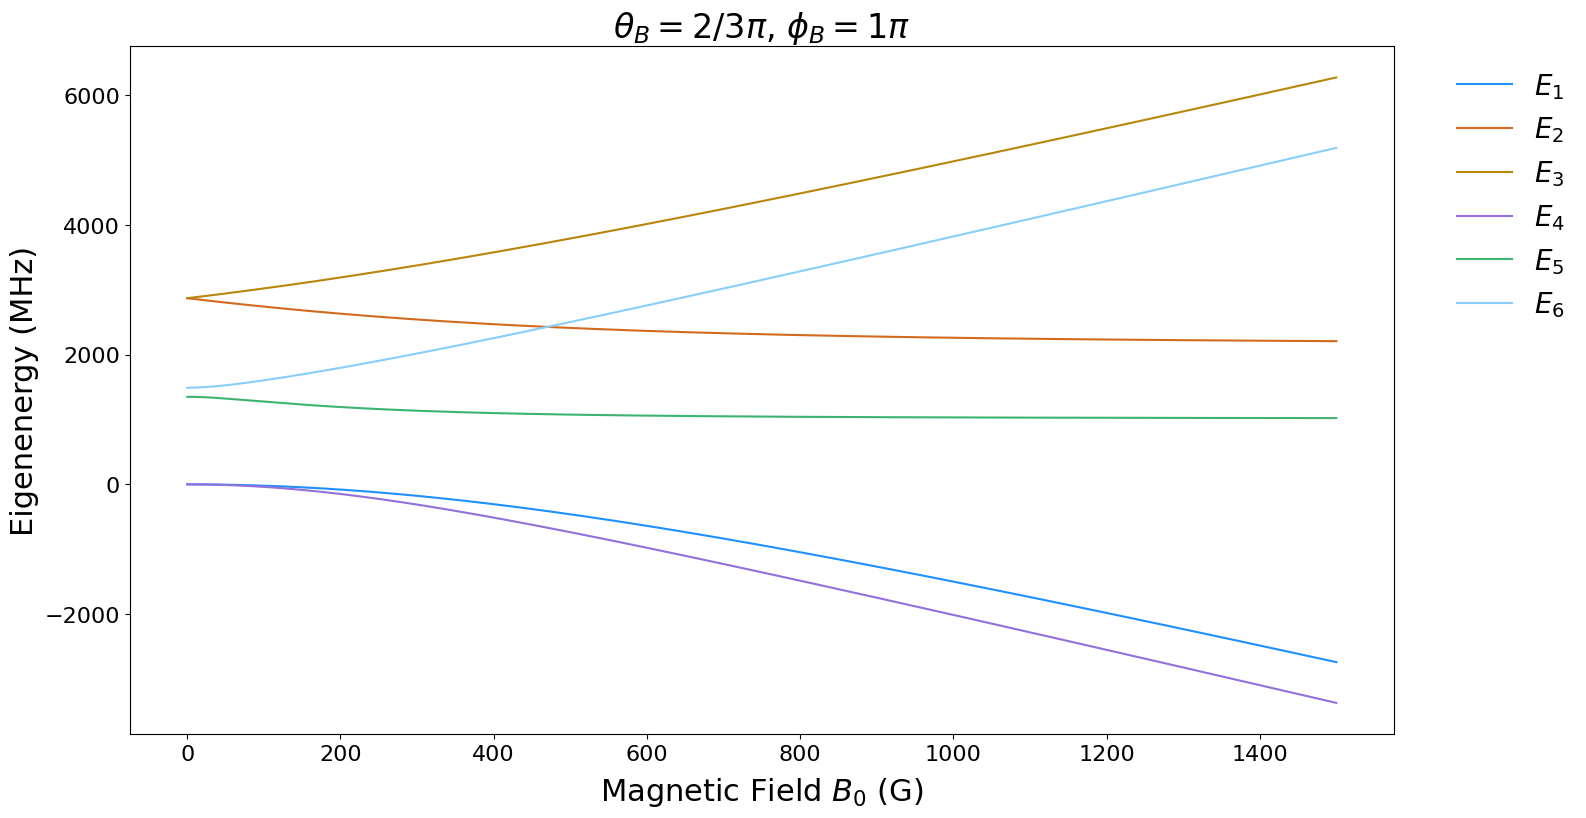

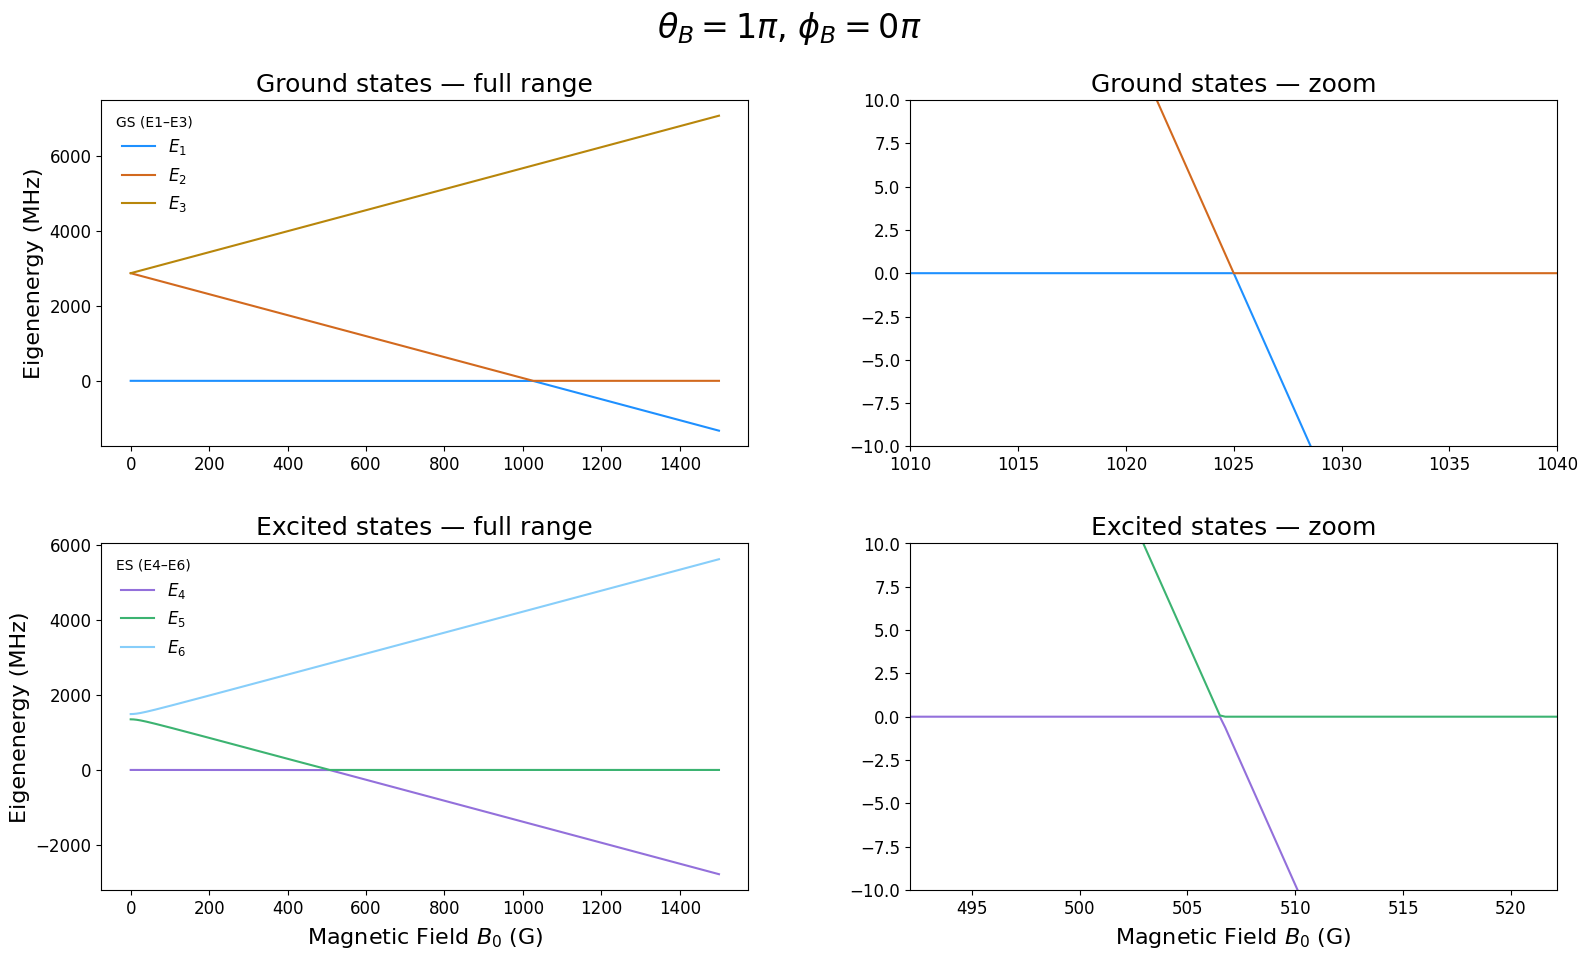

In [6]:
import os
import re

# ------------------------ appearance defaults ------------------------
# ---- labels / colors ----
label = ["$E_1$","$E_2$","$E_3$","$E_4$","$E_5$","$E_6$"]
e_colors = [
    "dodgerblue", "chocolate", "darkgoldenrod",
    "mediumpurple", "mediumseagreen", "lightskyblue"
]

# RGB definitions for LaTeX xcolor (matching the names above)
_MPL_COLOR_RGB = {
    "dodgerblue":     (30, 144, 255),
    "chocolate":      (210, 105,  30),
    "darkgoldenrod":  (184, 134,  11),
    "mediumpurple":   (147, 112, 219),
    "mediumseagreen": (60, 179, 113),
    "lightskyblue":   (135, 206, 250),
}

# ---- B values to tabulate (dedup + sort) ----
annotate_at_B = sorted(set([0, 100, 350, 475, 508, 525, 750, 1000, 1025, 1050, 1200]))

# ---- basis naming (remap to internal order) ----
user_labels_gs = [r"|1\rangle", r"|2\rangle", r"|3\rangle"]
internal_to_user_gs = [0, 2, 1]
basis_gs = [user_labels_gs[i] for i in internal_to_user_gs]

user_labels_es = [r"|4\rangle", r"|5\rangle", r"|6\rangle"]
internal_to_user_es = [0, 2, 1]
basis_es = [user_labels_es[i] for i in internal_to_user_es]

# ---- focus controls for zooms (Gauss) ----
# Top-right (GS zoom): center and ±range in B
B_focus_gs = 2870/mu_e
r_gs       = 15
# Bottom-right (ES zoom): center and ±range in B
B_focus_es = 1420/mu_e  # convert MHz to G
r_es       = 15

# ---- NEW: vertical (energy) zoom controls (MHz) ----
# If Y_focus_* is None, no y-zoom is applied. Otherwise use [Y_focus_* - Ry_*, Y_focus_* + Ry_*].
Y_focus_gs = 0
Ry_gs      = 10
Y_focus_es = 0
Ry_es      = 10

# ------------------------ helpers ------------------------
def nearest_idx(xarr, x):
    return int(np.abs(xarr - x).argmin())

def superposition_label(vec_qobj, basis_labels, kmax=3, prob_thresh=0.005, gap=0.15,
                        decimals=3, terms_per_line=2):
    """
    Build a compact LaTeX label for a superposition in the provided basis.
    If a term would print as '1.00|i⟩' (to 'decimals' places), omit '1.00' and print only '|i⟩'.
    """
    v = np.array(vec_qobj.full()).ravel()
    if v.size == 0:
        core_lines = [basis_labels[0]]
    else:
        top = np.argmax(np.abs(v))
        ang0 = np.angle(v[top]) if np.abs(v[top]) > 0 else 0.0
        v = v * np.exp(-1j * ang0)

        probs = np.abs(v) ** 2
        order = np.argsort(probs)[::-1]
        pmax = probs[order[0]]

        sel = [i for i in order if (probs[i] >= prob_thresh) or (probs[i] >= pmax - gap)]
        sel = sel[:kmax] if len(sel) > kmax else sel
        if not sel:
            sel = [order[0]]

        def fmt_term(i):
            amp = np.abs(v[i])
            s = f"{amp:.{decimals}f}"
            if s == f"{1.0:.{decimals}f}":
                return f"{basis_labels[i]}"
            return f"{s}{basis_labels[i]}"

        terms = [fmt_term(i) for i in sel]
        core_lines = []
        for s in range(0, len(terms), terms_per_line):
            chunk = terms[s:s+terms_per_line]
            if s > 0 and not chunk[0].startswith("-"):
                chunk[0] = "+" + chunk[0]
            core_lines.append("+".join(chunk).replace("+-", "-"))

    fmt = (r"${line}$")
    lines = [fmt.format(line=L) for L in core_lines]
    return "\n".join(lines), len(lines)

# ---------- write LaTeX table to file (ABNTEX-style float) ----------
def save_table_as_tex(filepath, col_labels, rows, caption, label_tex):
    """
    Writes an ABNTEX-style table float (no preamble). Intended for \\input{...}.
    NOTE: Your main LaTeX preamble should include \\usepackage{physics} so \\ket{} is defined.
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    num_levels = len(col_labels) - 1

    def latex_levels(s: str) -> str:
        return re.sub(r"\|(\d+)\\rangle", r"\\ket{\1}", s).replace("\n", r"")

    header_cells = [r"\textbf{B}"] + [rf"\textbf{{{col_labels[j]}}}" for j in range(1, num_levels + 1)]
    header_line  = " & ".join(header_cells) + r" \\"

    body_lines = []
    for r in rows:
        bval = r[0]
        cells = [bval] + [latex_levels(c) for c in r[1:]]
        body_lines.append("    " + " & ".join(cells) + r" \\")
    body_block = "\n\\hline\n".join(body_lines)  # fixed invalid escape

    col_spec = "l|" + "c"*num_levels

    tex = rf"""% Requires in preamble: \usepackage{{physics}}
\begin{{table}}[hbt]
  \ABNTEXfontereduzida
  \caption{{{caption}}}
  \label{{{label_tex}}}
  \centering
  \begin{{tabular}}{{{col_spec}}}
    \hline
    {header_line}
    \hline
{body_block}
    \hline
  \end{{tabular}}
  \begin{{flushleft}}
    Source: By the author
  \end{{flushleft}}
\end{{table}}
"""
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(tex)

# ------------------------ MAIN ------------------------
init_b = 0
os.makedirs("Figs", exist_ok=True)
os.makedirs("Tables", exist_ok=True)
B_END = 1500

thetas = [0.0, np.pi/2, 2*np.pi/3, np.pi]
phis   = [0.0, np.pi/2, 2*np.pi/3, np.pi]

for thetab in thetas:
    for phib in phis:

        # ---- sweep field ----
        B_values = np.arange(init_b, B_END, 0.25)

        # pass 1: eigenenergies only (fast)
        energies_gs = np.empty((len(B_values), 3))
        energies_es = np.empty((len(B_values), 3))
        for k, i in enumerate(B_values):
            bs = B0(i, phib, thetab)
            H  = H_no(bs, 0.0)[0]
            H_full = H.full()
            h_gs = qt.Qobj(H_full[:3,  :3])
            h_es = qt.Qobj(H_full[3:6, 3:6])
            energies_gs[k] = h_gs.eigenenergies()
            energies_es[k] = h_es.eigenenergies()

        # ---- decide which B's we actually have and map to indices ----
        k_list = [nearest_idx(B_values, x) for x in annotate_at_B
                  if (B_values.min() <= x <= B_values.max())]
        k_list = sorted(set(k_list))

        # pass 2: eigenstates only at required rows (avoid 1200× eigenvectors)
        rows = []
        max_lines = 1
        num_levels = 6
        col_labels = ["B"] + label

        for k in k_list:
            i = B_values[k]
            bs = B0(i, phib, thetab)
            H  = H_no(bs, 0.0)[0]
            H_full = H.full()
            h_gs = qt.Qobj(H_full[:3,  :3])
            h_es = qt.Qobj(H_full[3:6, 3:6])
            _, evecs_g = h_gs.eigenstates()
            _, evecs_e = h_es.eigenstates()

            row = [str(i)]
            for j in range(num_levels):
                vec = evecs_g[j] if j < 3 else evecs_e[j-3]
                txt, nL = superposition_label(
                    vec, basis_gs if j < 3 else basis_es,
                    kmax=3, prob_thresh=0.005, gap=0.15, decimals=3,
                    terms_per_line=2
                )
                row.append(txt)
                max_lines = max(max_lines, nL)
            rows.append(row)

        # ---------- PLOTTING ----------
        theta_frac = Fraction(thetab/np.pi).limit_denominator()
        phi_frac   = Fraction(phib/np.pi).limit_denominator()

        special_layout = (np.isclose(thetab, 0.0) or np.isclose(thetab, np.pi)) and np.isclose(phib, 0.0)

        if special_layout:
            # 2×2 grid: GS full/zoom (top), ES full/zoom (bottom)
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # no sharey so we can y-zoom independently

            ax_gs_full  = axes[0, 0]
            ax_gs_zoom  = axes[0, 1]
            ax_es_full  = axes[1, 0]
            ax_es_zoom  = axes[1, 1]

            # --- top row: first 3 energies (ground-state block)
            for j in range(3):
                y = energies_gs[:, j]
                ax_gs_full.plot(B_values, y, label=label[j], color=e_colors[j])
                #if j not in excl_gs:
                ax_gs_zoom.plot(B_values, y, label=label[j], color=e_colors[j])

            # --- bottom row: last 3 energies (excited-state block)
            for j in range(3, 6):
                y = energies_es[:, j-3]
                ax_es_full.plot(B_values, y, label=label[j], color=e_colors[j])
                #if (j-3) not in excl_es:  # indices 0..2 within ES block
                ax_es_zoom.plot(B_values, y, label=label[j], color=e_colors[j])

            fig.suptitle(f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$", fontsize=24, y=0.99)

            # Titles
            ax_gs_full.set_title("Ground states — full range", fontsize=18)
            ax_es_full.set_title("Excited states — full range", fontsize=18)
            ax_gs_zoom.set_title(
                rf"Ground states — zoom",#@ ${B_focus_gs:.2f}\,\mathrm{{G}}\pm{r_gs}\,\mathrm{{G}}$",
                fontsize=18
            )
            ax_es_zoom.set_title(
                rf"Excited states — zoom", #@ ${B_focus_es:.2f}\,\mathrm{{G}}\pm{r_es}\,\mathrm{{G}}$",
                fontsize=18
            )

            # Labels
            ax_gs_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)
            ax_es_zoom.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)

            # Horizontal zoom windows (symmetric in B)
            ax_gs_zoom.set_xlim(B_focus_gs - r_gs, B_focus_gs + r_gs)
            ax_es_zoom.set_xlim(B_focus_es - r_es, B_focus_es + r_es)

            # ---- NEW: Vertical zoom windows (if specified)
            if Y_focus_gs is not None:
                ax_gs_zoom.set_ylim(Y_focus_gs - Ry_gs, Y_focus_gs + Ry_gs)
            if Y_focus_es is not None:
                ax_es_zoom.set_ylim(Y_focus_es - Ry_es, Y_focus_es + Ry_es)

            # Ticks/legends
            for ax in (ax_gs_full, ax_gs_zoom, ax_es_full, ax_es_zoom):
                ax.tick_params(labelsize=12)
            ax_gs_full.legend(loc="best", fontsize=12, frameon=False, title="GS (E1–E3)")
            ax_es_full.legend(loc="best", fontsize=12, frameon=False, title="ES (E4–E6)")

            fig.subplots_adjust(top=0.90, wspace=0.25, hspace=0.28, left=0.07, right=0.98)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_GRID_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        else:
            # Original single-axes plot for all other angles
            fig = plt.figure(figsize=(16, 8.0))
            ax  = fig.add_subplot(111)

            for j in range(num_levels):
                y = energies_gs[:, j] if j < 3 else energies_es[:, j-3]
                ax.plot(B_values, y, label=label[j], color=e_colors[j])

            ax.set_title(
                f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$",
                fontsize=24
            )
            ax.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=22, labelpad=8)
            ax.set_ylabel('Eigenenergy (MHz)', fontsize=22)
            ax.tick_params(labelsize=16)
            ax.legend(bbox_to_anchor=(1.03, 1), loc="upper left", fontsize=20, frameon=False)

            fig.subplots_adjust(top=0.96, bottom=0.10, left=0.07, right=0.86)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_SINGLE_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        # ---------- save LaTeX table (ABNTEX-style) ----------
        tex_path   = f'Tables/energy_levels_table_t-{int(100*thetab)}_p-{int(100*phib)}.tex'
        caption    = rf"Eigenstate compositions at $\theta_B={theta_frac}\pi$, $\phi_B={phi_frac}\pi$."
        label_tex  = rf"tab:energy_levels_t-{int(100*thetab)}_p-{int(100*phib)}"

        save_table_as_tex(tex_path, col_labels, rows, caption, label_tex)

        # keep only the first phi when theta is 0 or pi (i.e., run only phi=0 for theta=0,π)
        if np.isclose(thetab, 0) or np.isclose(thetab, np.pi):
            break

plt.close('all')

## Model 2

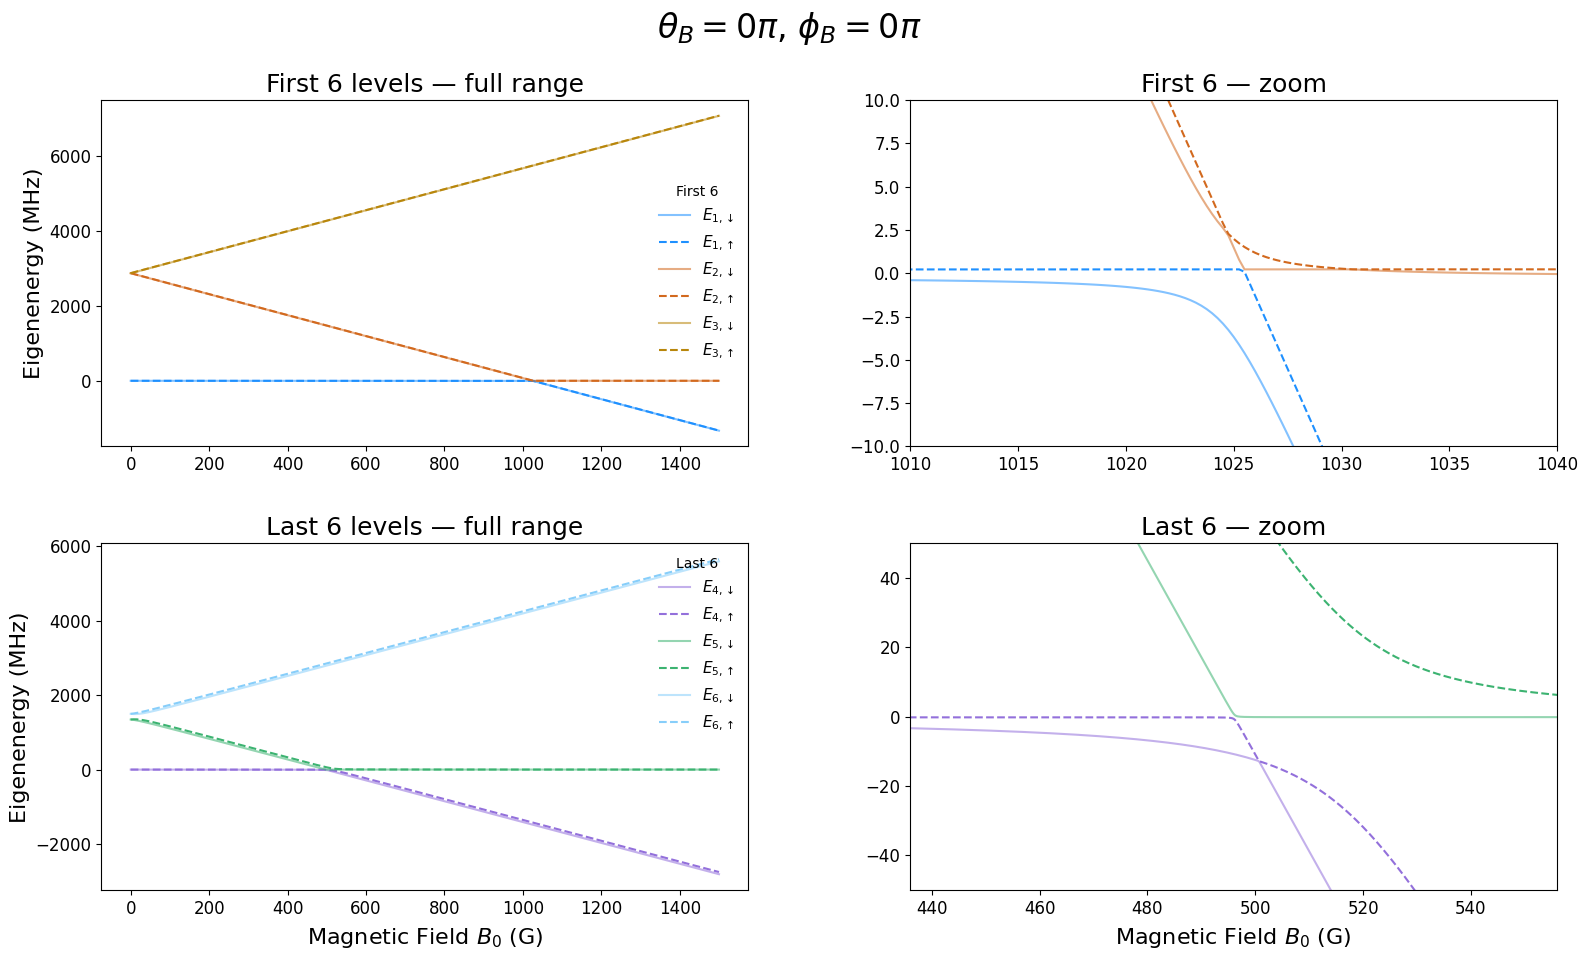

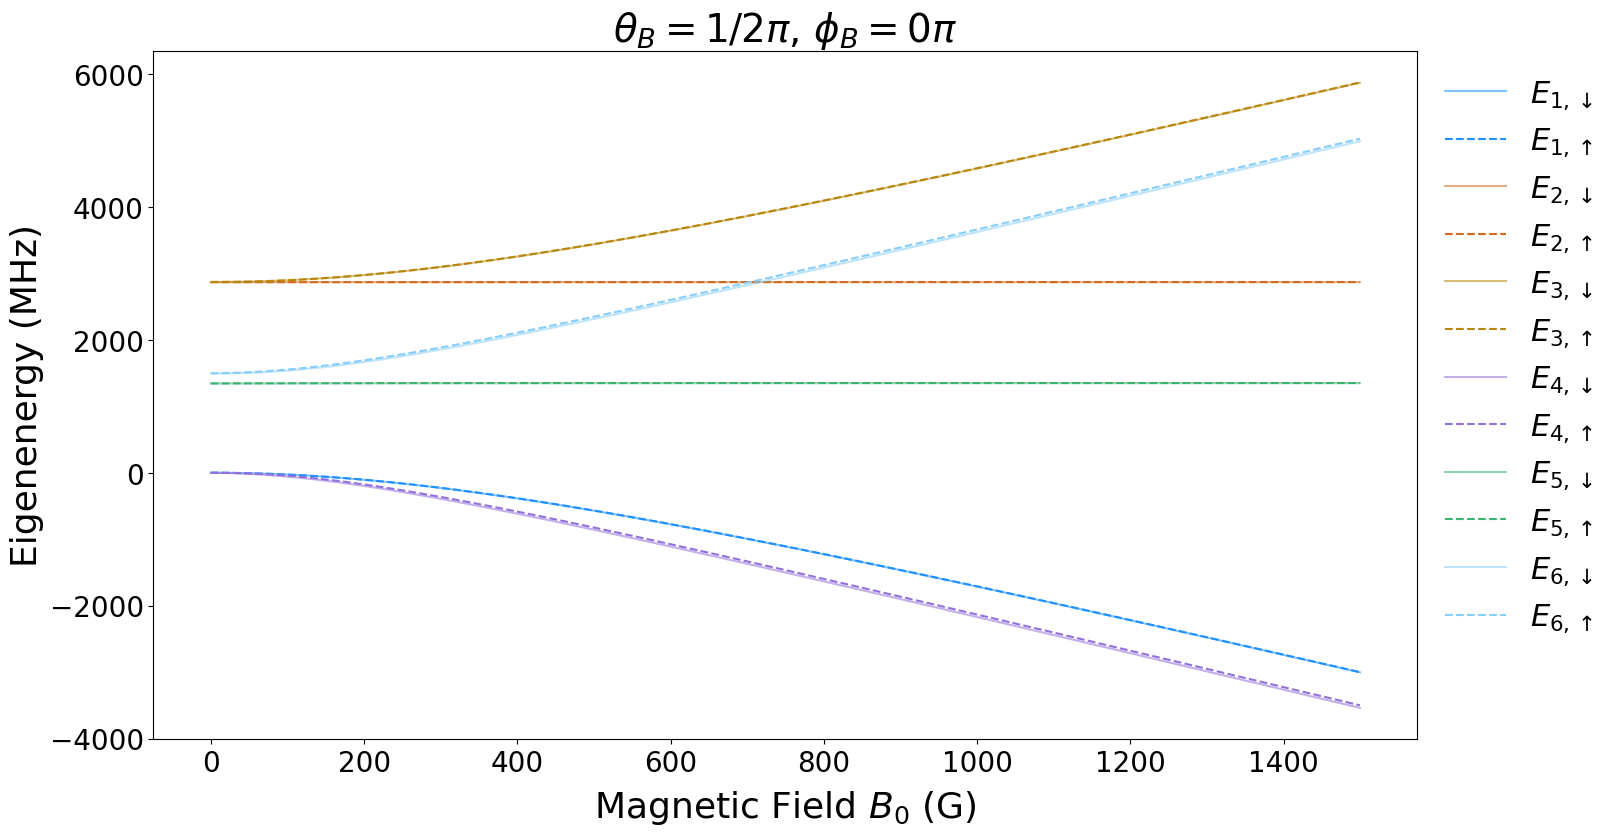

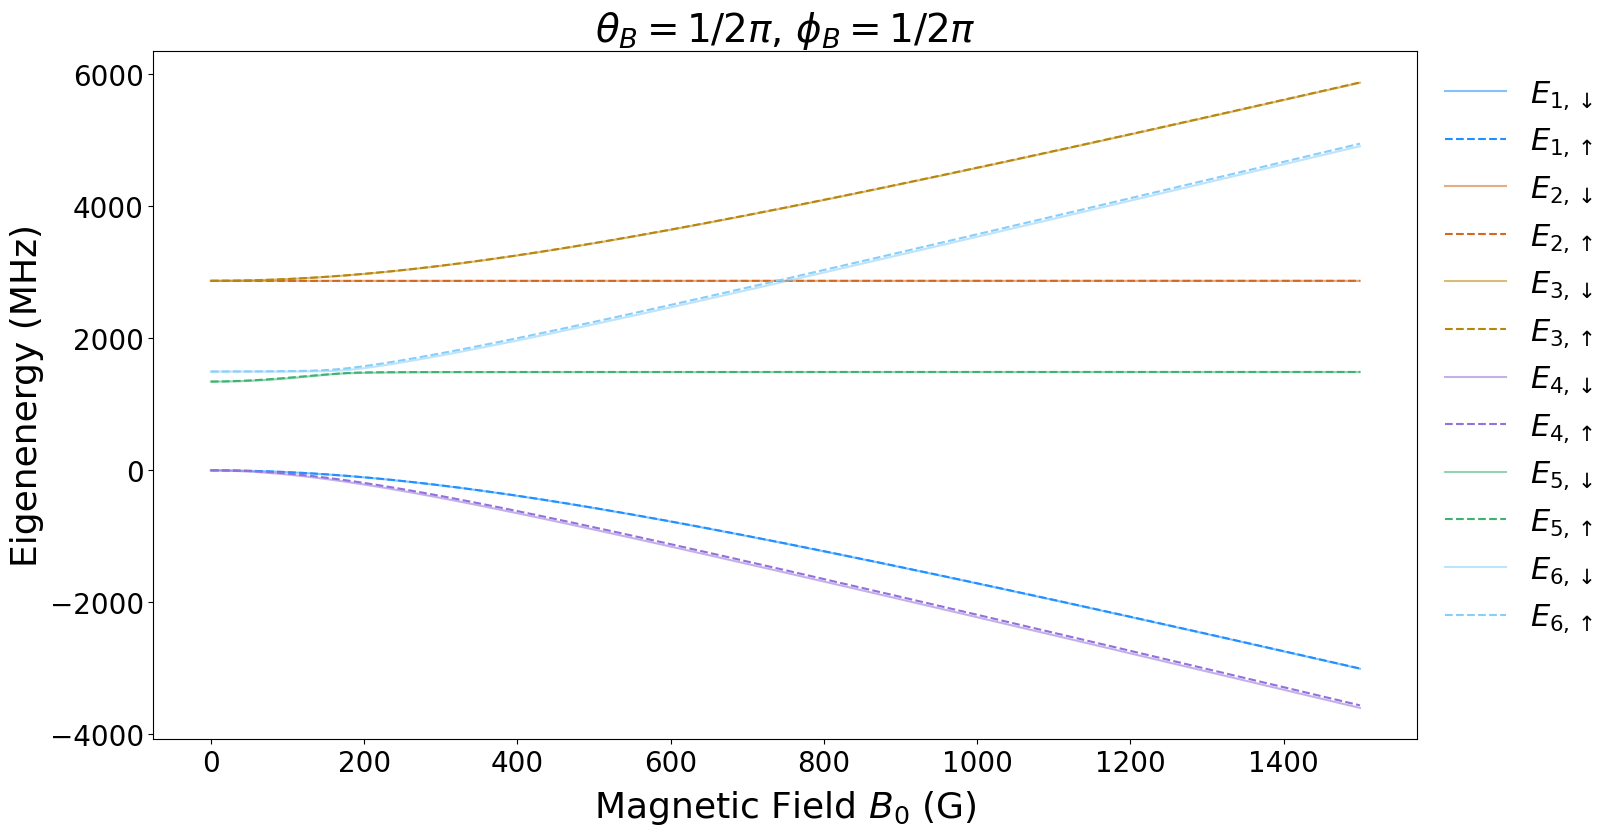

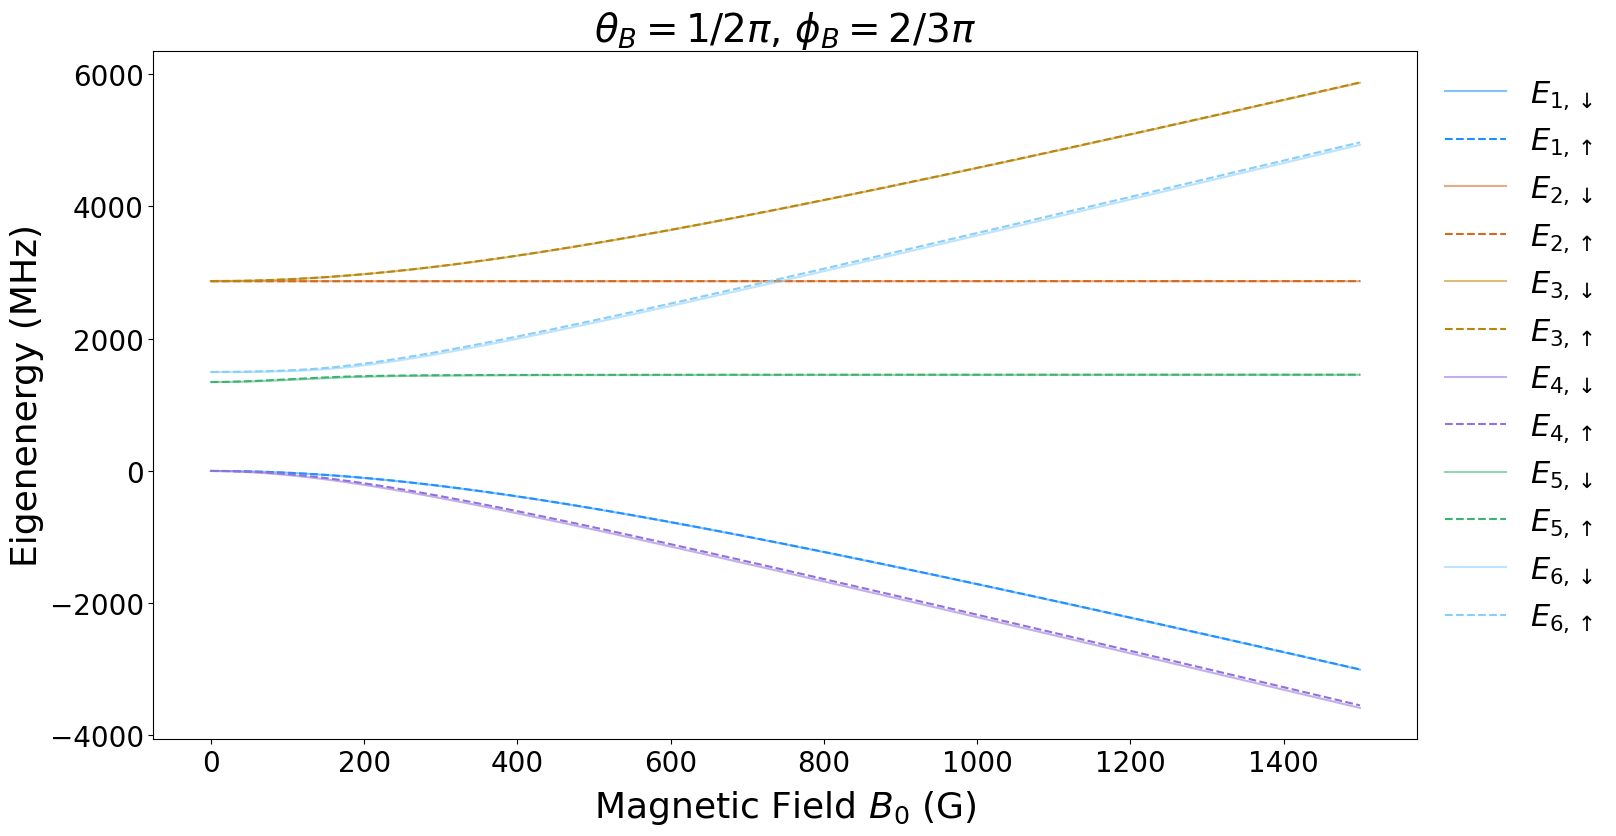

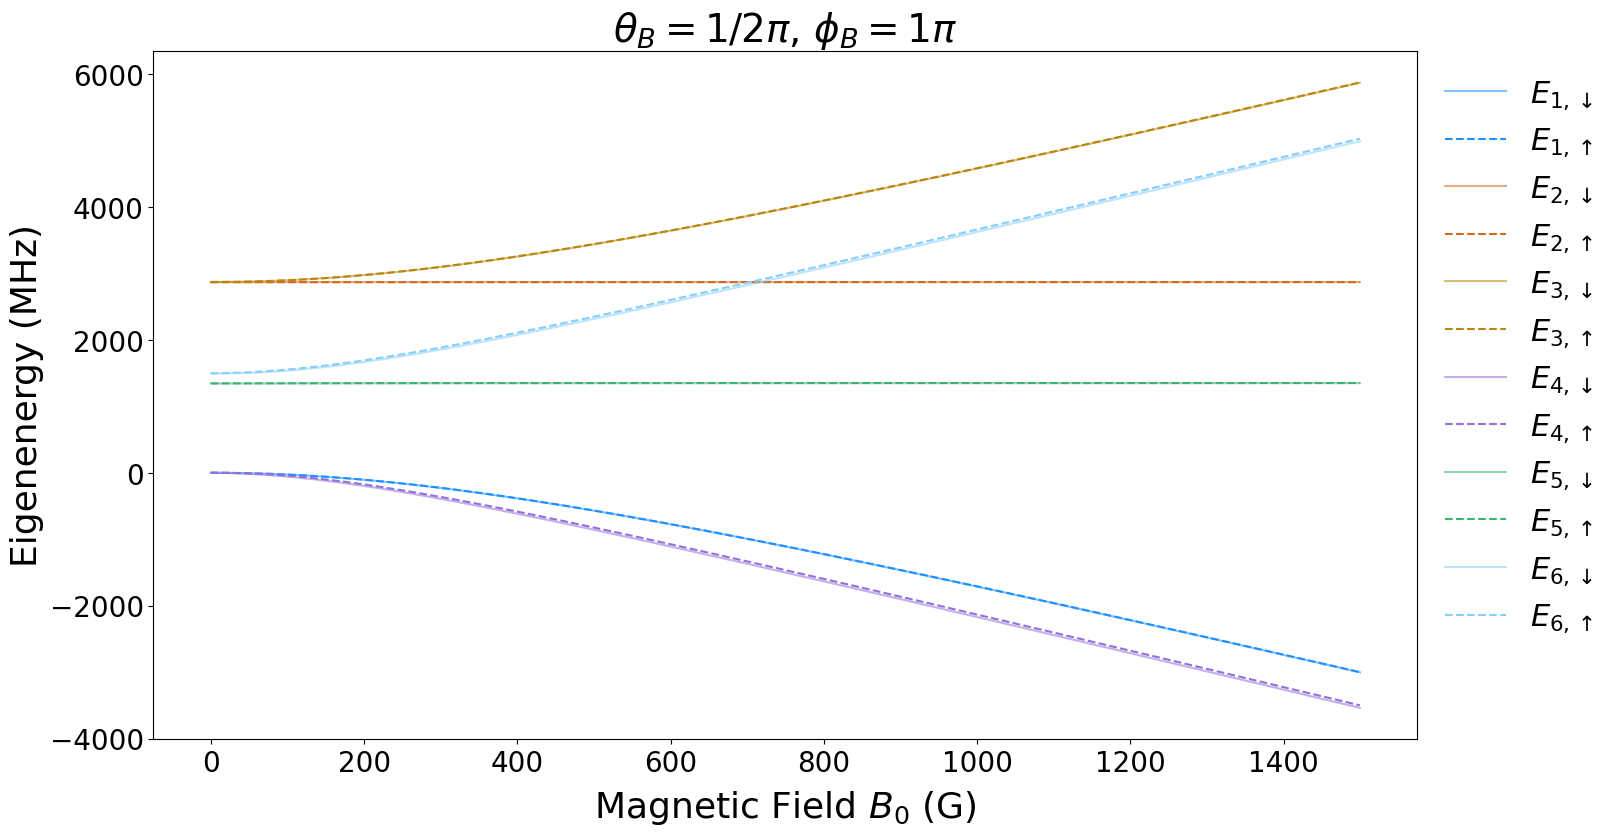

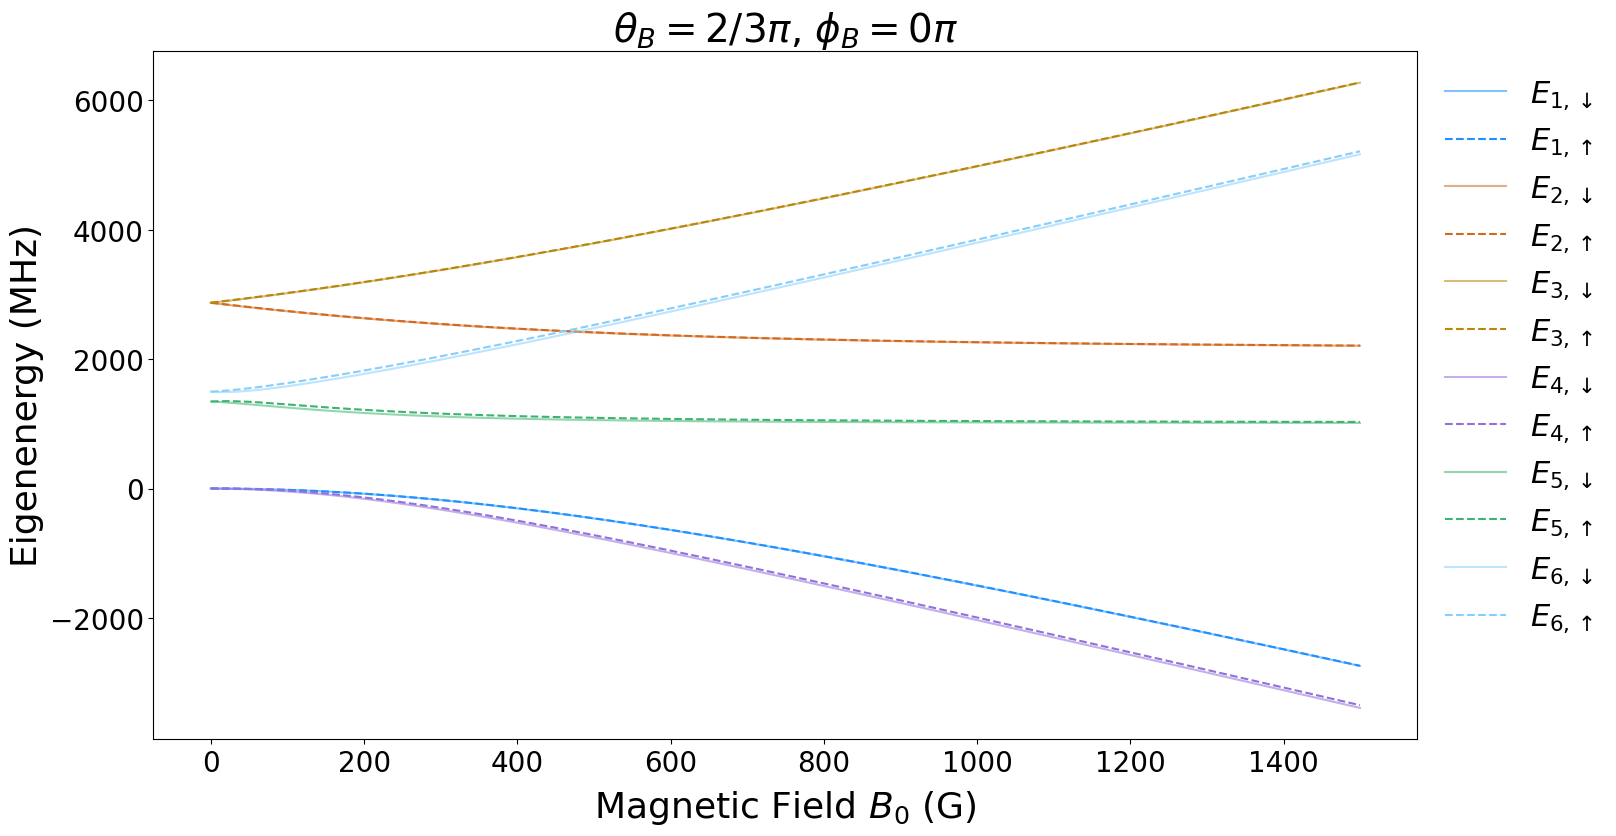

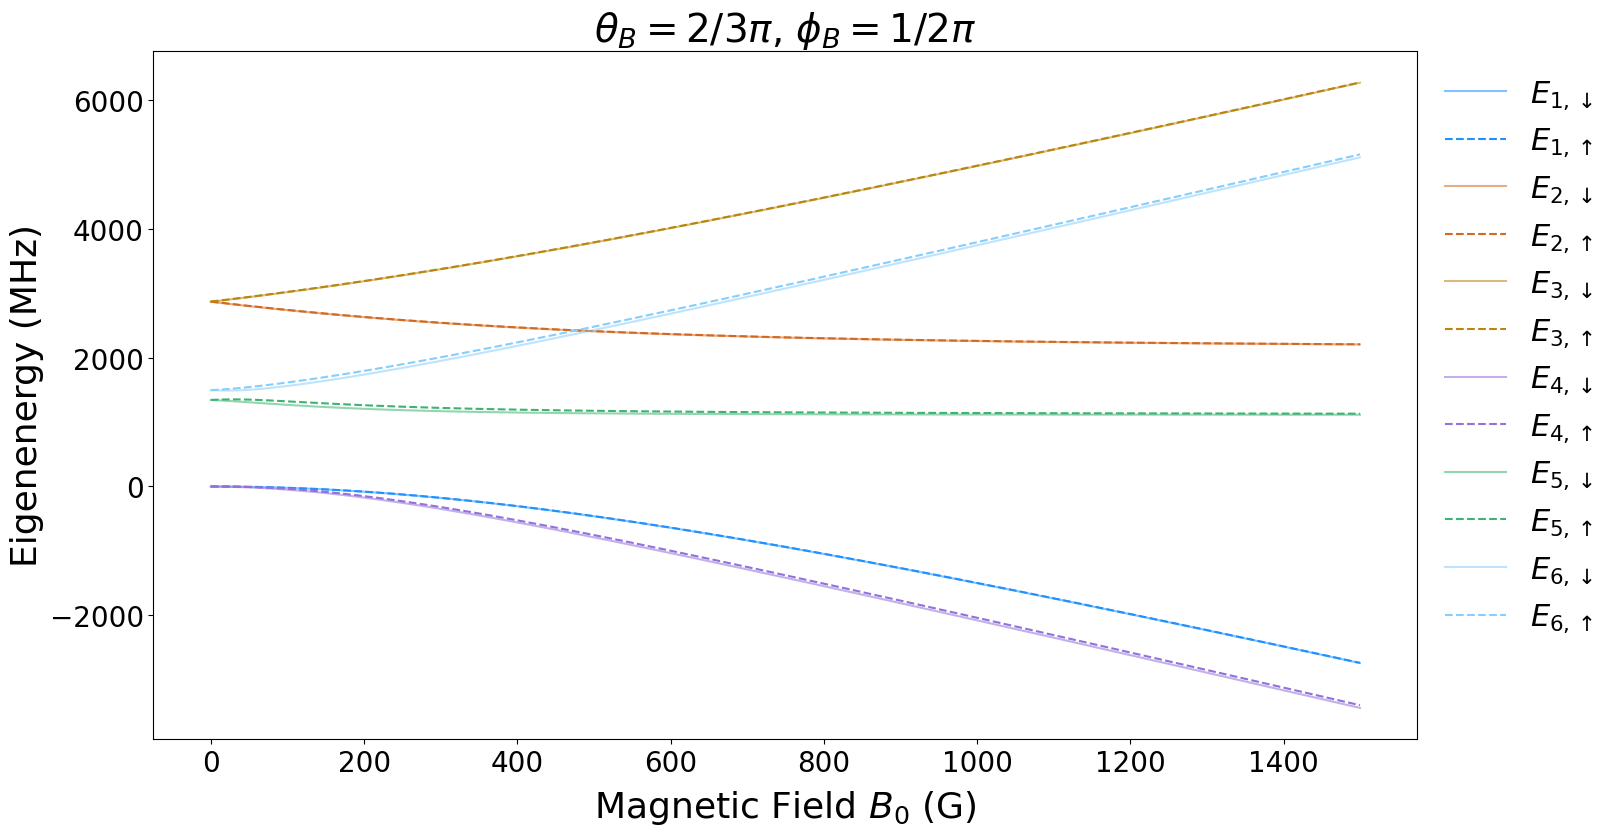

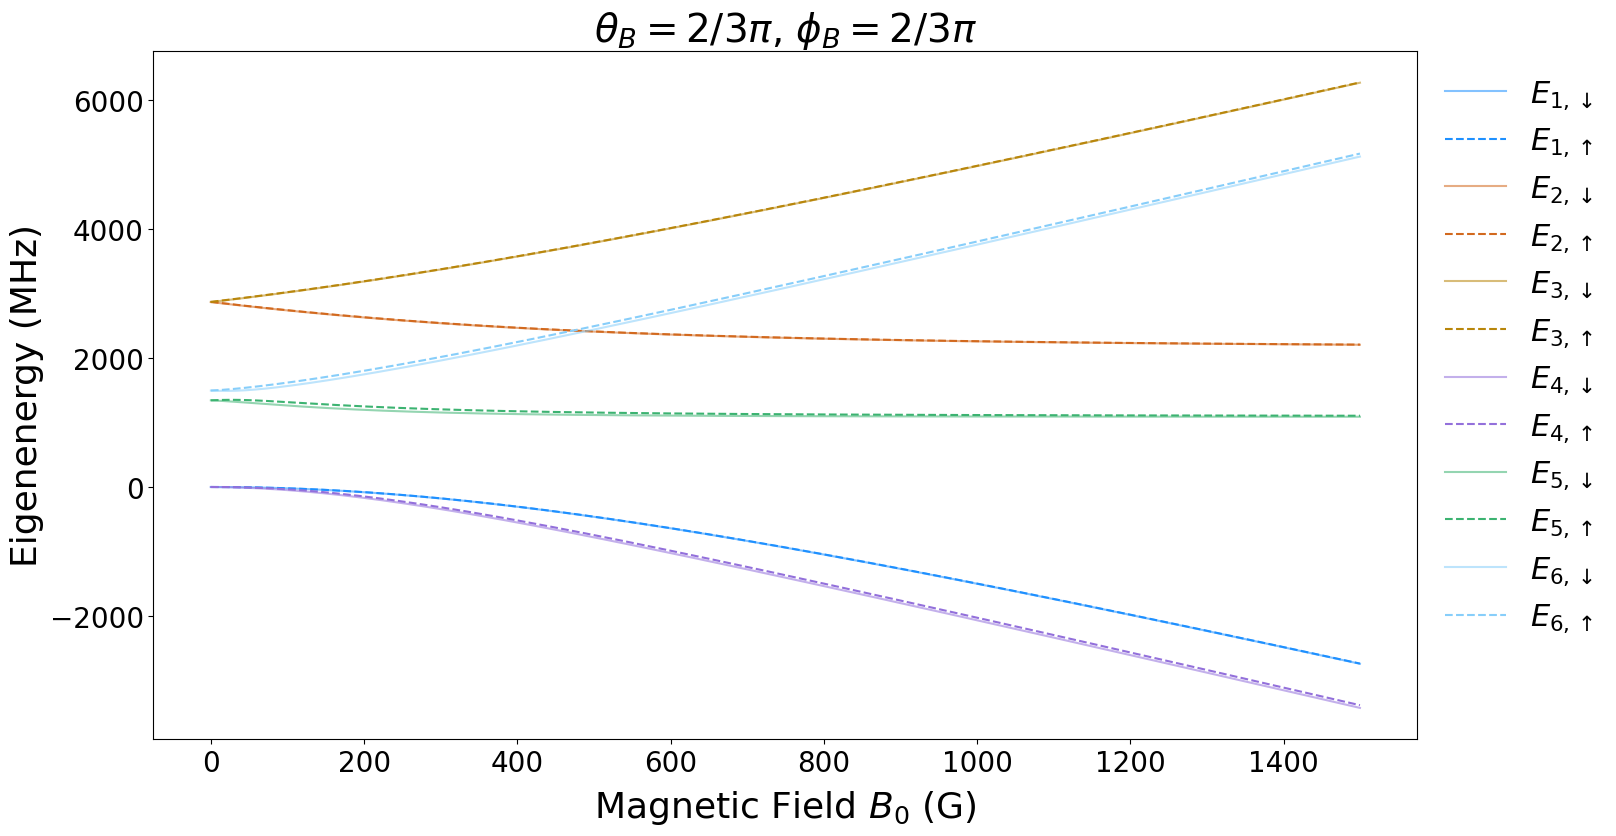

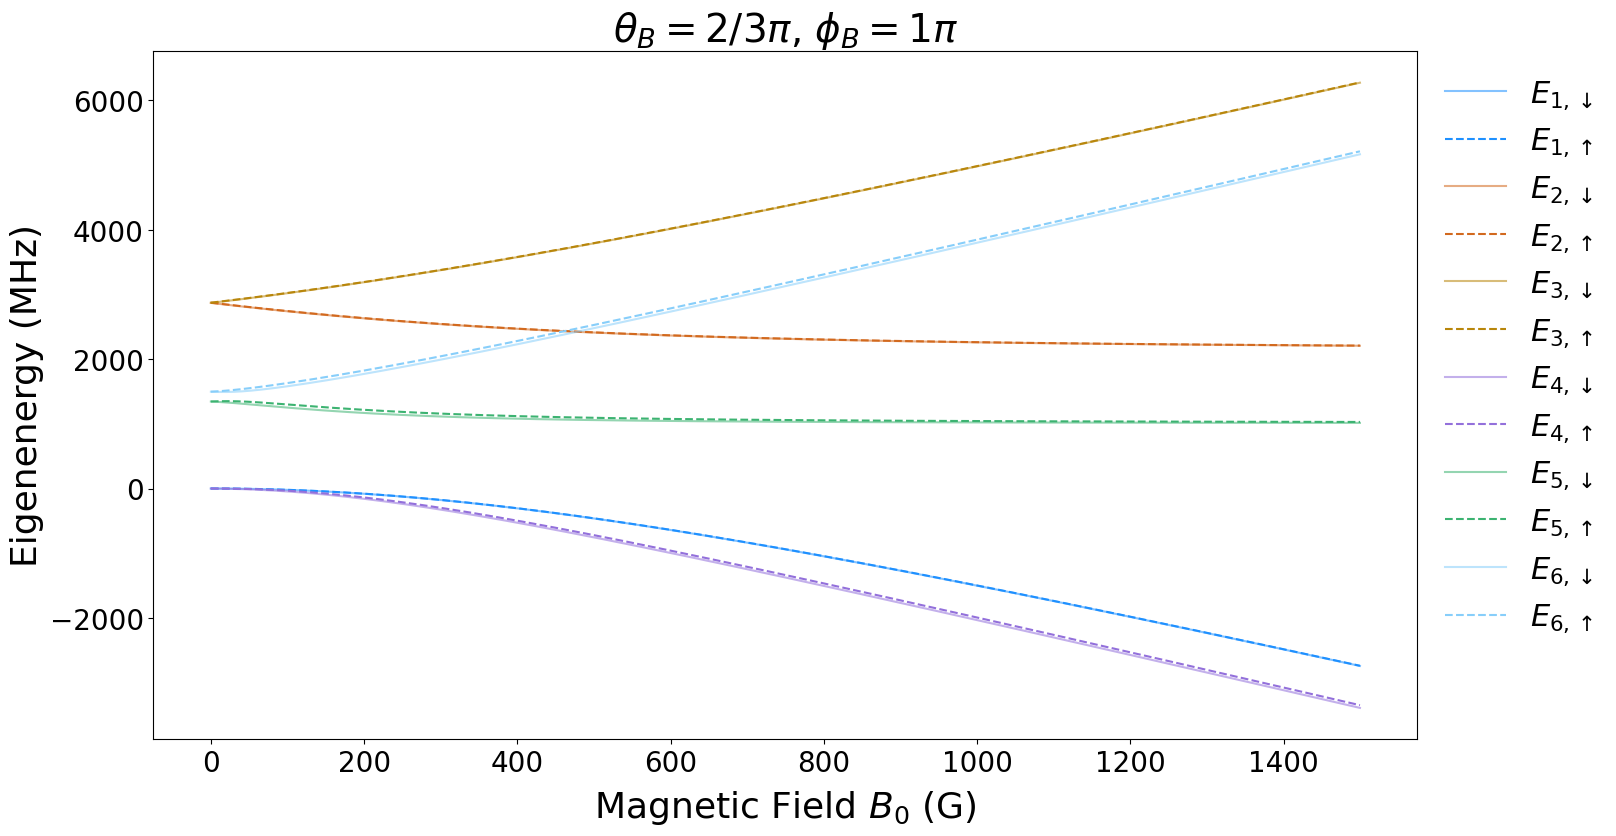

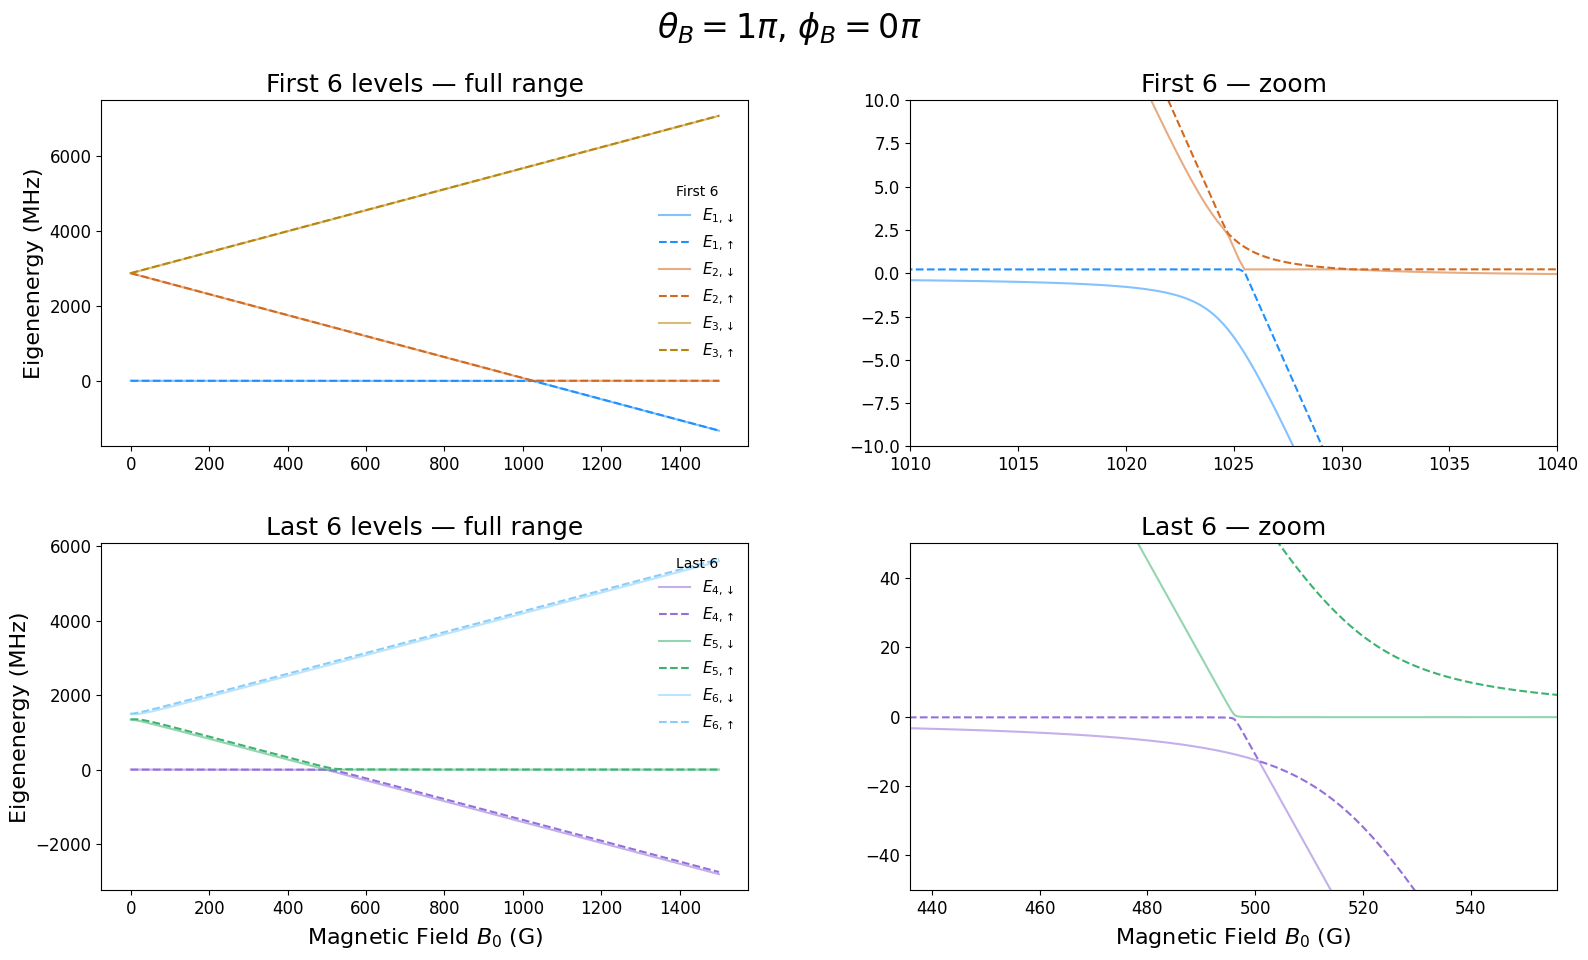

In [7]:
import os
import re

# ------------------------ labels / colors ------------------------
labels = [
    r"$E_{1,\downarrow}$", r"$E_{1,\uparrow}$",
    r"$E_{2,\downarrow}$", r"$E_{2,\uparrow}$",
    r"$E_{3,\downarrow}$", r"$E_{3,\uparrow}$",
    r"$E_{4,\downarrow}$", r"$E_{4,\uparrow}$",
    r"$E_{5,\downarrow}$", r"$E_{5,\uparrow}$",
    r"$E_{6,\downarrow}$", r"$E_{6,\uparrow}$",
]
# Pairs share a color; ↑ is dashed.
e_colors = [
    "dodgerblue", "chocolate", "darkgoldenrod",
    "mediumpurple", "mediumseagreen", "lightskyblue", "magenta"
]

# ---------- table rows at the SAME B values ----------
annotate_at_B = sorted(set([0, 100, 350, 475, 508, 525, 750, 1000, 1025, 1050, 1200]))

# ---------- BASIS LABELS (match to your *internal* basis order) ----------
user_labels_gs6 = [
    r"|1,\downarrow\rangle", r"|1,\uparrow\rangle",
    r"|2,\downarrow\rangle", r"|2,\uparrow\rangle",
    r"|3,\downarrow\rangle", r"|3,\uparrow\rangle",
]
internal_to_user_gs6 = [0, 1, 4, 5, 2, 3]
basis_gs6 = [user_labels_gs6[i] for i in internal_to_user_gs6]

user_labels_es6 = [
    r"|4,\downarrow\rangle", r"|4,\uparrow\rangle",
    r"|5,\downarrow\rangle", r"|5,\uparrow\rangle",
    r"|6,\downarrow\rangle", r"|6,\uparrow\rangle",
]
internal_to_user_es6 = [0, 1, 4, 5, 2, 3]
basis_es6 = [user_labels_es6[i] for i in internal_to_user_es6]

# ---------- horizontal zoom controls (Gauss) ----------
B_focus_gs = 2870/mu_e
r_gs       = 15
B_focus_es = 496 # convert MHz to G
r_es       = 60

# ---------- NEW: vertical zoom controls (MHz) ----------
# If Y_focus_* is None, no y-zoom is applied on the zoom panels.
Y_focus_gs = 0.0   # e.g. 2870.0
Ry_gs      = 10.0
Y_focus_es = 0.0   # e.g. 1500.0
Ry_es      = 50.0

# ---------- helpers ----------
def nearest_idx(xarr, x):
    return int(np.abs(xarr - x).argmin())

def superposition_label(vec_qobj, basis_labels, kmax=6, prob_thresh=0.005, gap=0.15,
                        decimals=3, terms_per_line=2, pad_math_lines=0):
    """Return (cell_text, n_lines); multi-line, each line wrapped in its own $...$.
       If a coefficient prints as '1.00' (to 'decimals'), omit it and show only the state."""
    v = np.array(vec_qobj.full()).ravel()
    if v.size == 0:
        core_lines = [basis_labels[0]]
    else:
        # fix global phase (largest component real-positive)
        top = np.argmax(np.abs(v))
        ang0 = np.angle(v[top]) if np.abs(v[top]) > 0 else 0.0
        v = v * np.exp(-1j * ang0)

        probs = np.abs(v) ** 2
        order = np.argsort(probs)[::-1]
        pmax = probs[order[0]]

        sel = [i for i in order if (probs[i] >= prob_thresh) or (probs[i] >= pmax - gap)]
        sel = sel[:kmax] if len(sel) > kmax else sel
        if not sel:
            sel = [order[0]]

        def fmt_term(i):
            amp = np.abs(v[i])
            s = f"{amp:.{decimals}f}"
            if s == f"{1.0:.{decimals}f}":
                return f"{basis_labels[i]}"
            return f"{s}{basis_labels[i]}"

        terms = [fmt_term(i) for i in sel]
        core_lines = []
        for s in range(0, len(terms), terms_per_line):
            chunk = terms[s:s+terms_per_line]
            if s > 0 and not chunk[0].startswith("-"):
                chunk[0] = "+" + chunk[0]
            core_lines.append("+".join(chunk).replace("+-", "-"))

    fmt = (r"${line}$")
    lines = [fmt.format(line=L) for L in core_lines]
    if pad_math_lines > 0:
        pad = "$\\,$"
        lines = [pad]*pad_math_lines + lines + [pad]*pad_math_lines
    return "\n".join(lines), len(lines)

# ---------- LaTeX table writer (ABNTEX-style float; no preamble) ----------
def save_table_as_tex(filepath, col_labels, rows, caption, label):
    """
    Writes an ABNTEX-style table float. Use \\input{...} in your main doc.
    Cells may contain \\shortstack and internal line breaks (\\).
    Your preamble must include: \\usepackage{physics} (for \\ket{}).
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    num_levels = len(col_labels) - 1

    header_cells = [r"\textbf{B}"] + [c for c in col_labels[1:]]
    header_line  = " & ".join(header_cells) + r" \\"

    body_lines = []
    for r in rows:
        bval  = r[0]
        cells = [bval] + r[1:]  # already formatted
        body_lines.append("    " + " & ".join(cells) + r" \\")
    body_block = "\n\\hline\n".join(body_lines)  # fixed invalid escape

    col_spec = "l|" + "c"*num_levels

    tex = rf"""% Requires in preamble: \usepackage{{physics}}
\begin{{table}}[hbt]
  \ABNTEXfontereduzida
  \caption{{{caption}}}
  \label{{{label}}}
  \centering
  \begin{{tabular}}{{{col_spec}}}
    \hline
    {header_line}
    \hline
{body_block}
    \hline
  \end{{tabular}}
  \begin{{flushleft}}
    Source: By the author
  \end{{flushleft}}
\end{{table}}
"""
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(tex)

# ---------------------------------------------------------------
# MAIN: sweep, compute spectra, plot + write LaTeX table (stack ↑ under ↓)
# ---------------------------------------------------------------
init_b = 0
B_END = 1500
os.makedirs("Figs", exist_ok=True)
os.makedirs("Tables", exist_ok=True)

thetas = [0.0, np.pi/2, 2*np.pi/3, np.pi]
phis   = [0.0, np.pi/2, 2*np.pi/3, np.pi]

for thetab in thetas:
    for phib in phis:

        # ---- sweep field (energies only: fast pass) ----
        B_values = np.arange(init_b, B_END, 0.25)
        nB = len(B_values)

        energies_gs = np.empty((nB, 6))
        energies_es = np.empty((nB, 6))

        for k, i in enumerate(B_values):
            bs = B0(i, phib, thetab)
            # full 12×12 via TWO calls (pattern preserved)
            H  = H_dua_hf(bs, 0.0, 0.0)[0] + H_dua_hf(bs, 0.0, 0.0)[1]
            H_full = H.full()
            h_gs = qt.Qobj(H_full[:6,  :6])        # GS 6×6
            h_es = qt.Qobj(H_full[6:12, 6:12])     # ES 6×6
            energies_gs[k] = h_gs.eigenenergies()
            energies_es[k] = h_es.eigenenergies()

        # ---- indices for table rows ----
        k_list = [nearest_idx(B_values, x) for x in annotate_at_B
                  if (B_values.min() <= x <= B_values.max())]
        k_list = sorted(set(k_list))

        # ---- compute eigenstates only at table rows ----
        rows = []
        num_levels = 12

        # 6 headers: stack E_{i,↓} over E_{i,↑}
        pair_headers = []
        for i_pair in range(6):
            hd = labels[2*i_pair]     # already with $...$
            hu = labels[2*i_pair+1]
            pair_headers.append(rf"\shortstack{{\textbf{{{hd}}} \\ \textbf{{{hu}}}}}")
        col_labels = ["B"] + pair_headers

        def to_ket_and_preserve(s: str) -> str:
            s = re.sub(r"\|(.*?)\\rangle", r"\\ket{\1}", s)
            return s.replace("\n", r"\\")  # preserve multi-line layout

        for k in k_list:
            iB = B_values[k]
            bs = B0(iB, phib, thetab)
            H  = H_dua_hf(bs, 0.0, 0.0)[0] + H_dua_hf(bs, 0.0, 0.0)[1]
            H_full = H.full()

            h_gs = qt.Qobj(H_full[:6,  :6])
            h_es = qt.Qobj(H_full[6:12, 6:12])
            _, evecs_g = h_gs.eigenstates()
            _, evecs_e = h_es.eigenstates()

            state_strs = []
            for j in range(num_levels):
                vec = evecs_g[j] if j < 6 else evecs_e[j-6]
                txt, _ = superposition_label(
                    vec,
                    basis_gs6 if j < 6 else basis_es6,
                    kmax=6, prob_thresh=0.005, gap=0.15, decimals=3,
                    terms_per_line=2, pad_math_lines=0,
                )
                state_strs.append(to_ket_and_preserve(txt))

            # collapse to 6 columns: \shortstack of (down \\ up)
            pair_cells = []
            for i_pair in range(6):
                down_tex = state_strs[2*i_pair]
                up_tex   = state_strs[2*i_pair+1]
                pair_cells.append(rf"\shortstack[c]{{{down_tex} \\ {up_tex}}}")

            rows.append([str(iB)] + pair_cells)

        # ---------- PLOTTING ----------
        theta_frac = Fraction(thetab/np.pi).limit_denominator()
        phi_frac   = Fraction(phib/np.pi).limit_denominator()
        special_layout = (np.isclose(thetab, 0.0) or np.isclose(thetab, np.pi)) and np.isclose(phib, 0.0)

        if special_layout:
            # 2×2 grid: first 6 (top), last 6 (bottom); left=full, right=zoom
            # No sharey to allow vertical zoom on the right panels
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))

            ax_gs_full  = axes[0, 0]
            ax_gs_zoom  = axes[0, 1]
            ax_es_full  = axes[1, 0]
            ax_es_zoom  = axes[1, 1]

            # --- top row: first 6 levels (pairs share color; ↑ dashed)
            for j in range(6):
                y = energies_gs[:, j]
                pair_idx = j // 2  # 0→E1, 1→E2, 2→E3
                ax_gs_full.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )
                #if pair_idx not in excl_gs_pairs:
                ax_gs_zoom.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            # --- bottom row: last 6 levels
            for j in range(6, 12):
                y = energies_es[:, j-6]
                ax_es_full.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],  # pairs 3..5 map to indices 3..5
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )
                ax_es_zoom.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            fig.suptitle(f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$", fontsize=24, y=0.99)

            # Titles
            ax_gs_full.set_title("First 6 levels — full range", fontsize=18)
            ax_es_full.set_title("Last 6 levels — full range", fontsize=18)
            ax_gs_zoom.set_title(
                rf"First 6 — zoom",# @ ${B_focus_gs:.2f}\,\mathrm{{G}}\pm{r_gs}\,\mathrm{{G}}$",
                fontsize=18
            )
            ax_es_zoom.set_title(
                rf"Last 6 — zoom",# @ ${B_focus_es:.2f}\,\mathrm{{G}}\pm{r_es}\,\mathrm{{G}}$",
                fontsize=18
            )

            # Labels
            ax_gs_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)
            ax_es_zoom.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)

            # Horizontal zoom windows (symmetric)
            ax_gs_zoom.set_xlim(B_focus_gs - r_gs, B_focus_gs + r_gs)
            ax_es_zoom.set_xlim(B_focus_es - r_es, B_focus_es + r_es)

            # Vertical zoom windows (if specified)
            if Y_focus_gs is not None:
                ax_gs_zoom.set_ylim(Y_focus_gs - Ry_gs, Y_focus_gs + Ry_gs)
            if Y_focus_es is not None:
                ax_es_zoom.set_ylim(Y_focus_es - Ry_es, Y_focus_es + Ry_es)

            # Ticks/legends
            for ax in (ax_gs_full, ax_gs_zoom, ax_es_full, ax_es_zoom):
                ax.tick_params(labelsize=12)
            ax_gs_full.legend(loc="best", fontsize=11, frameon=False, title="First 6")
            ax_es_full.legend(loc="best", fontsize=11, frameon=False, title="Last 6")

            fig.subplots_adjust(top=0.90, wspace=0.25, hspace=0.28, left=0.07, right=0.98)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_M2_GRID_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        else:
            # Original single-axes plot for all other angles
            fig = plt.figure(figsize=(16, 8.0))
            ax  = fig.add_subplot(111)

            for j in range(num_levels):
                y = energies_gs[:, j] if j < 6 else energies_es[:, j-6]
                ax.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            ax.set_title(
                f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$",
                fontsize=28
            )
            ax.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=26, labelpad=8)
            ax.set_ylabel('Eigenenergy (MHz)', fontsize=26)
            ax.tick_params(labelsize=20)
            fig.subplots_adjust(left=0.07, right=0.86, top=0.96, bottom=0.10)
            ax.legend(bbox_to_anchor=(1.00, 1.00), loc="upper left", fontsize=22, frameon=False)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_M2_no_table_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        # ---- save LaTeX table (ABNTEX-style, 6 columns with stacked ↑/↓) ----
        tex_path   = f'Tables/energy_levels_M2_table_t-{int(100*thetab)}_p-{int(100*phib)}.tex'
        caption    = rf"Eigenstate compositions at $\theta_B={theta_frac}\pi$, $\phi_B={phi_frac}\pi$."
        label_tex  = rf"tab:energy_levels_M2_t-{int(100*thetab)}_p-{int(100*phib)}"

        save_table_as_tex(tex_path, col_labels, rows, caption, label_tex)

        # keep only the first phi when theta is 0 or pi (=> only (0,0) and (π,0))
        if np.isclose(thetab, 0) or np.isclose(thetab, np.pi):
            break

plt.close('all')

## Model 3

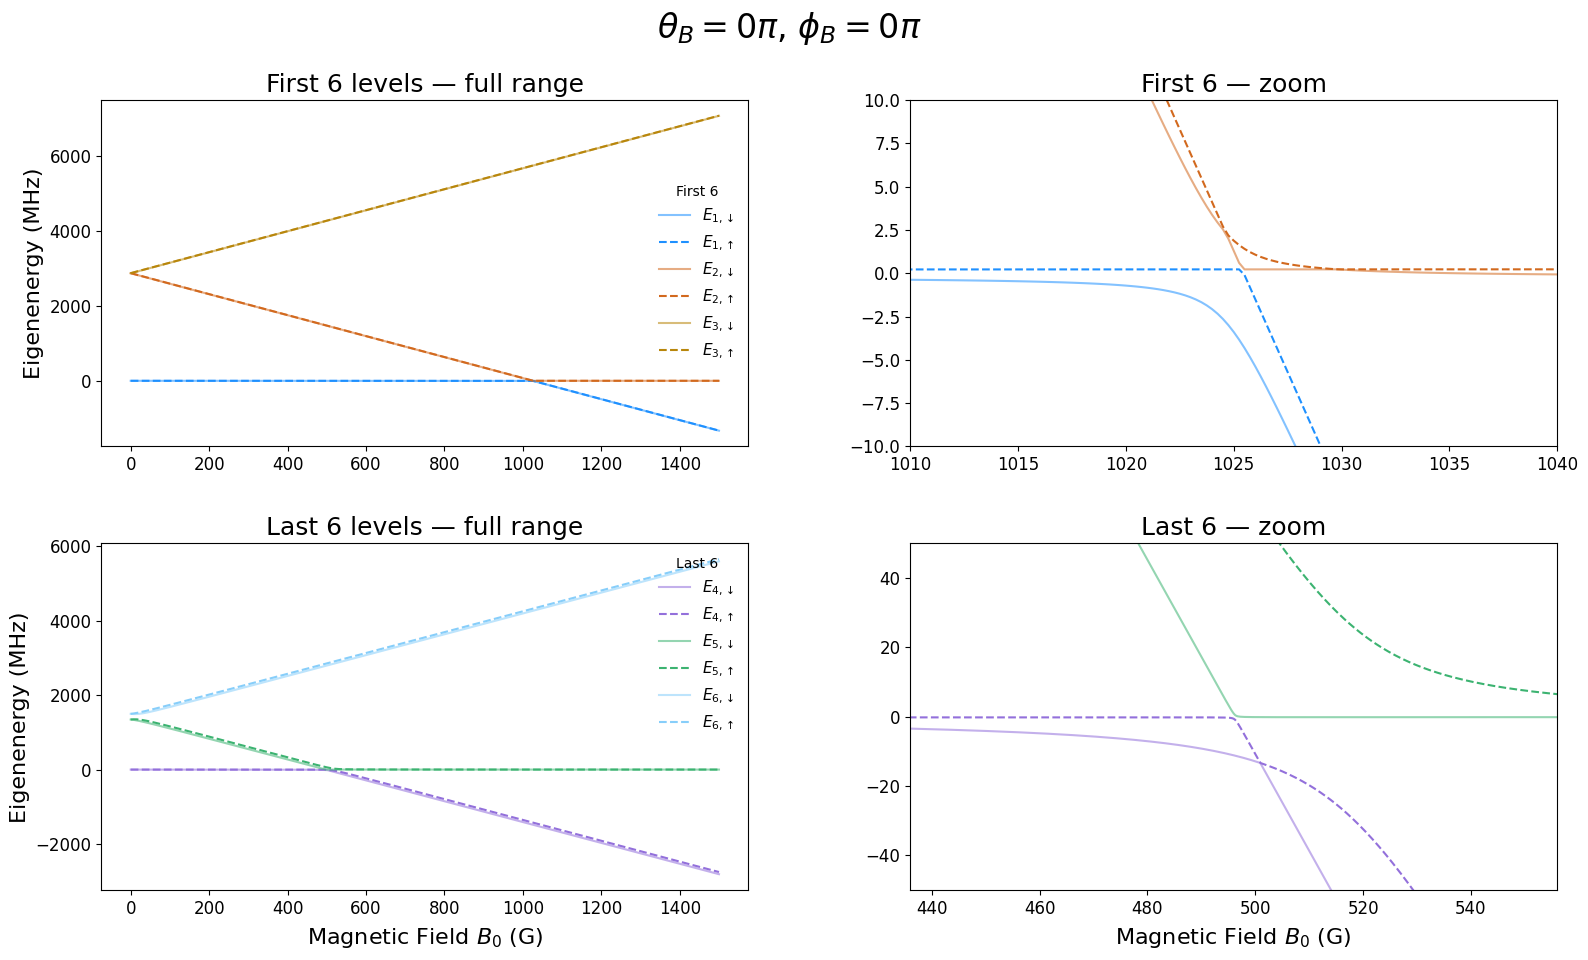

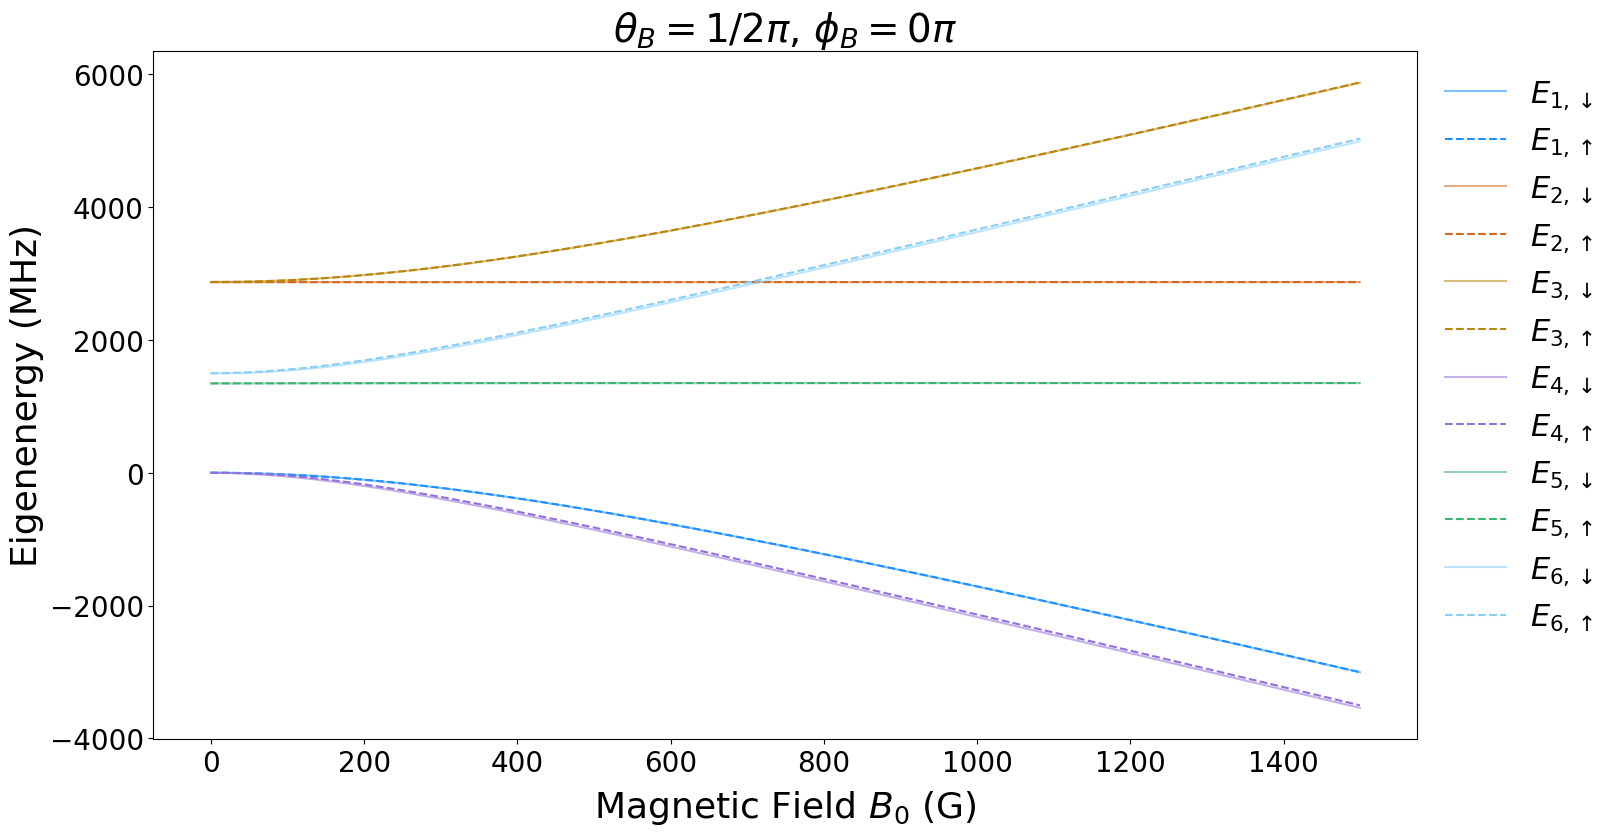

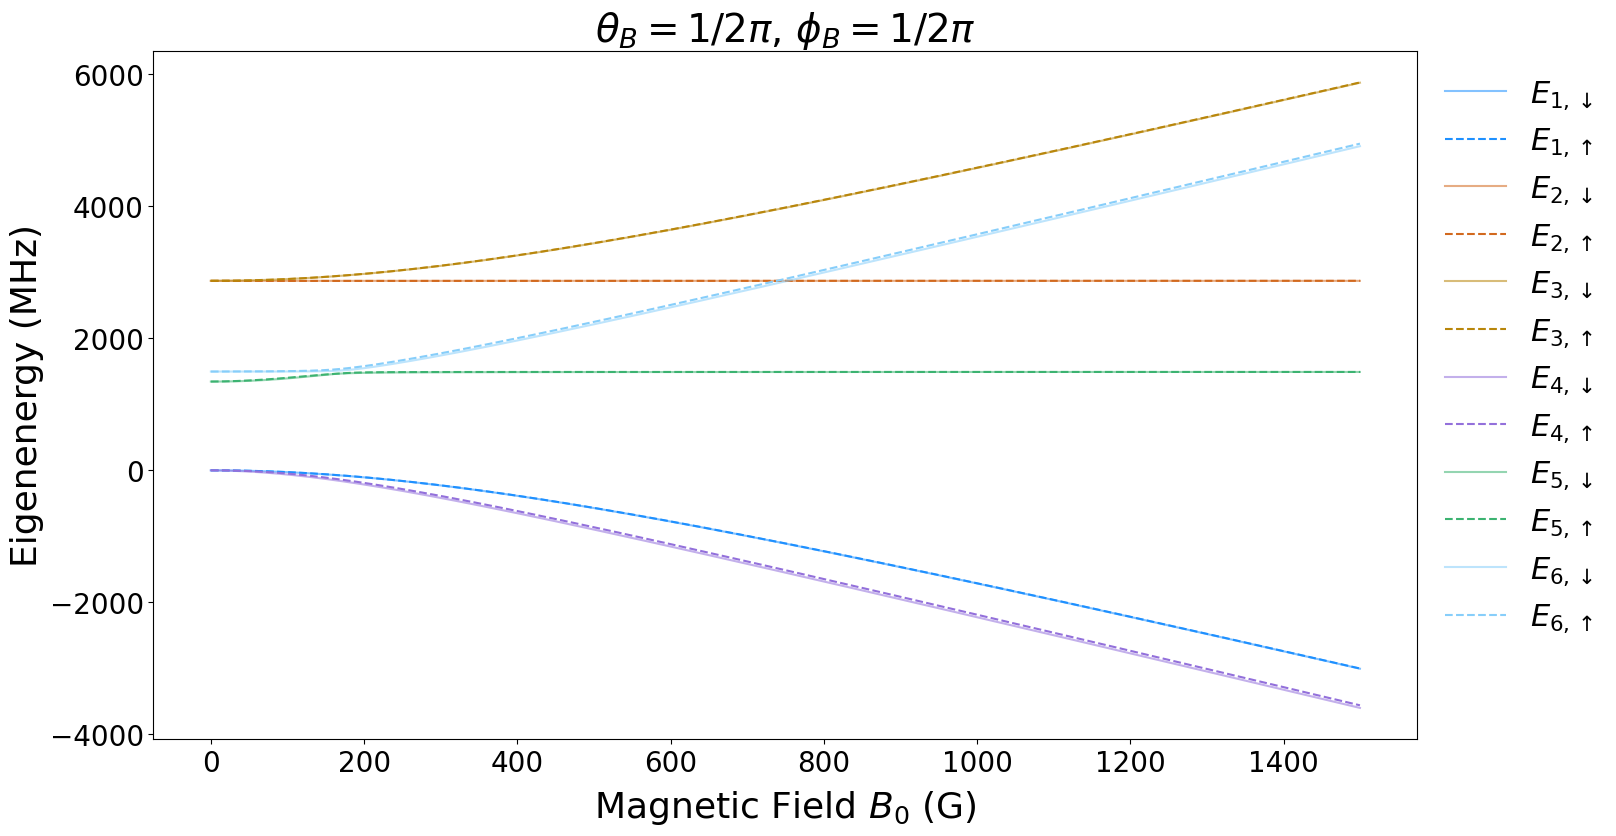

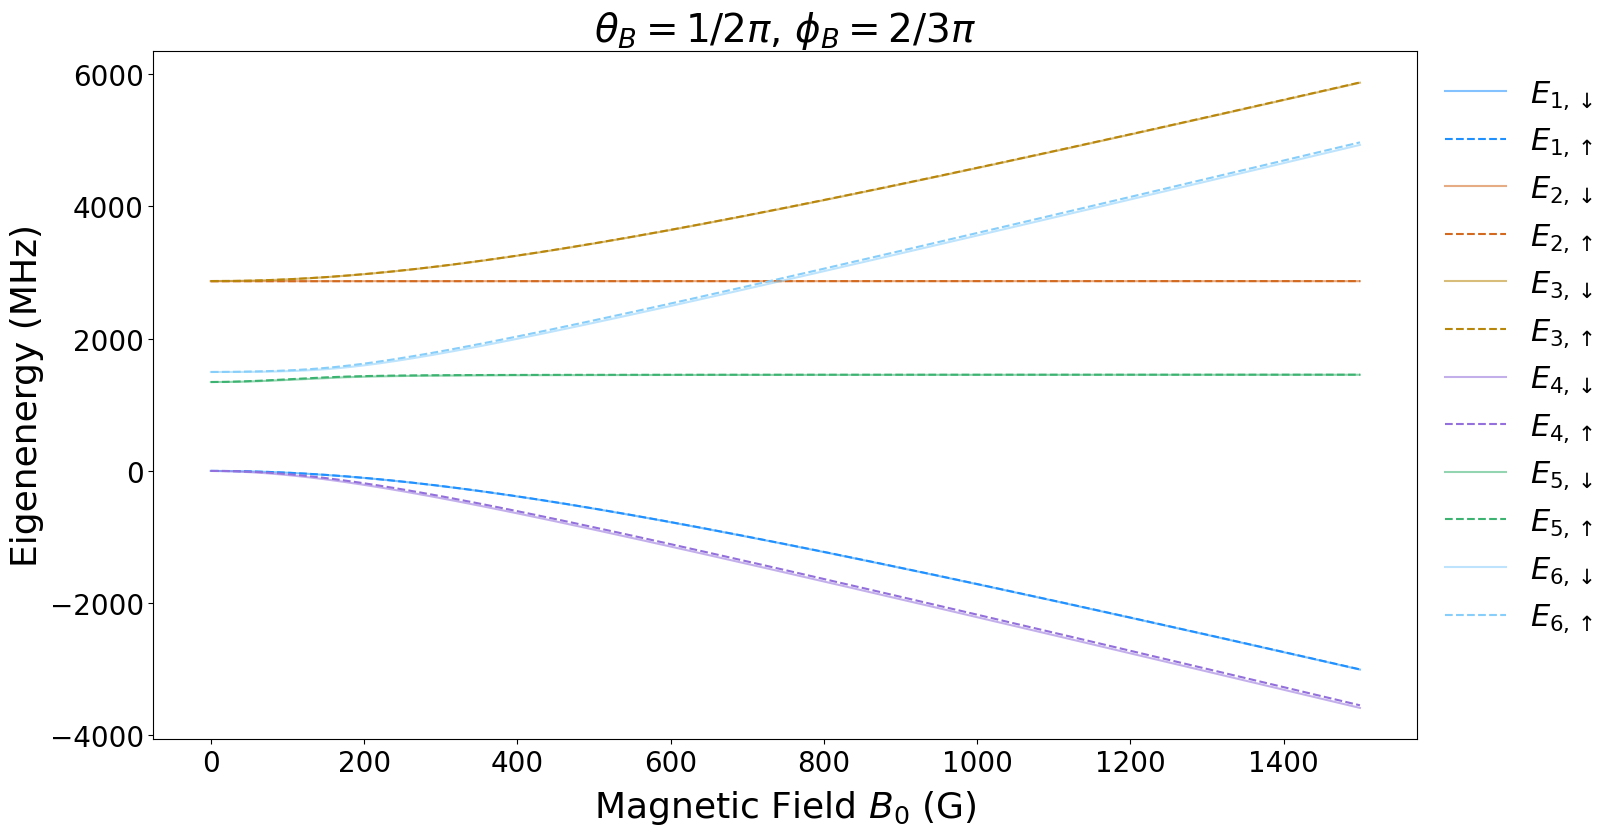

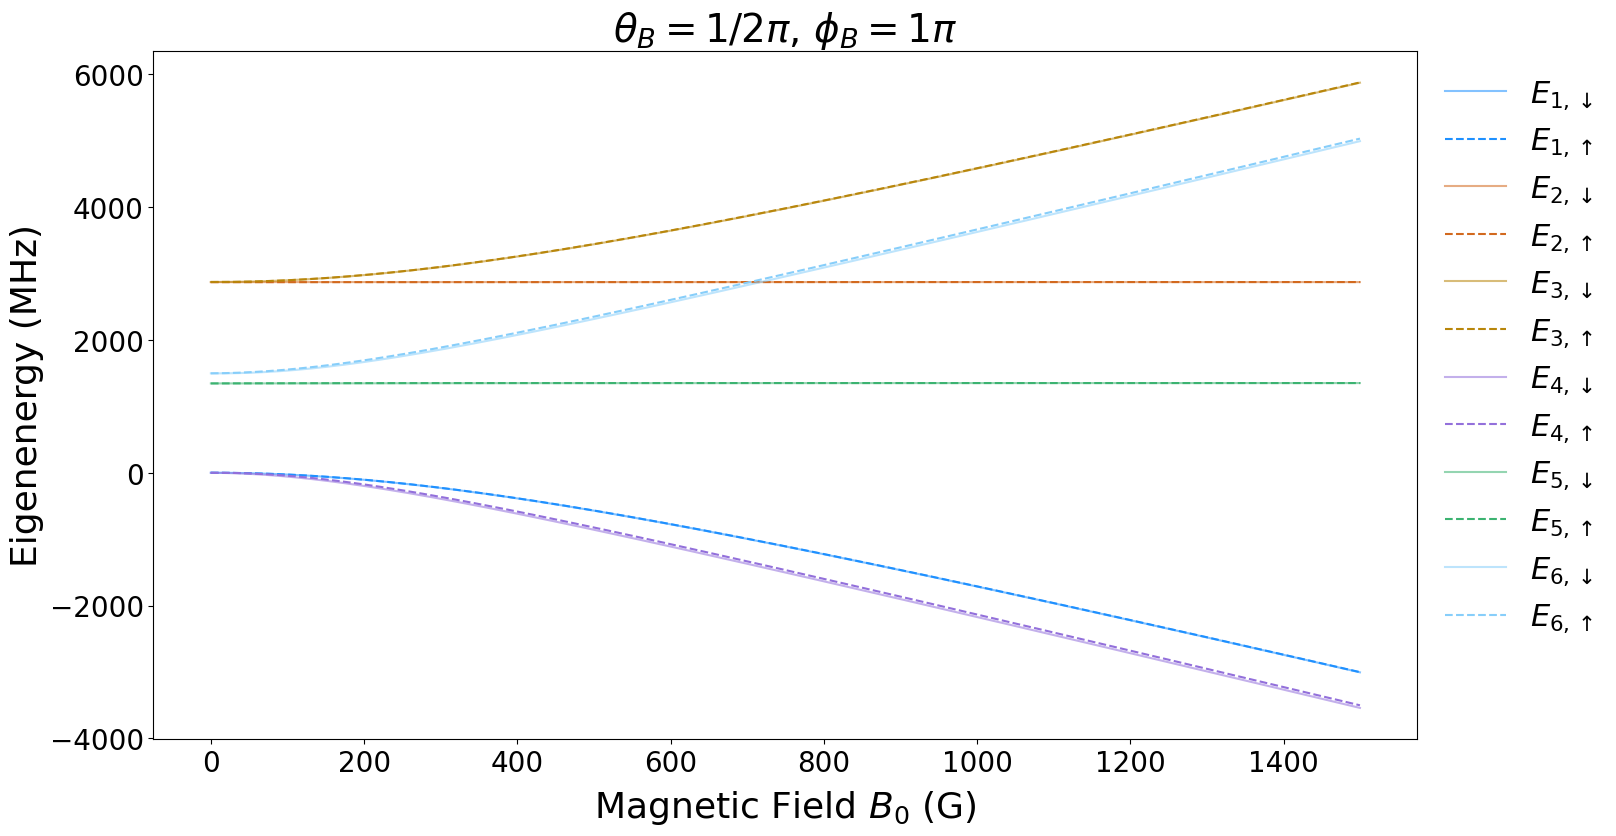

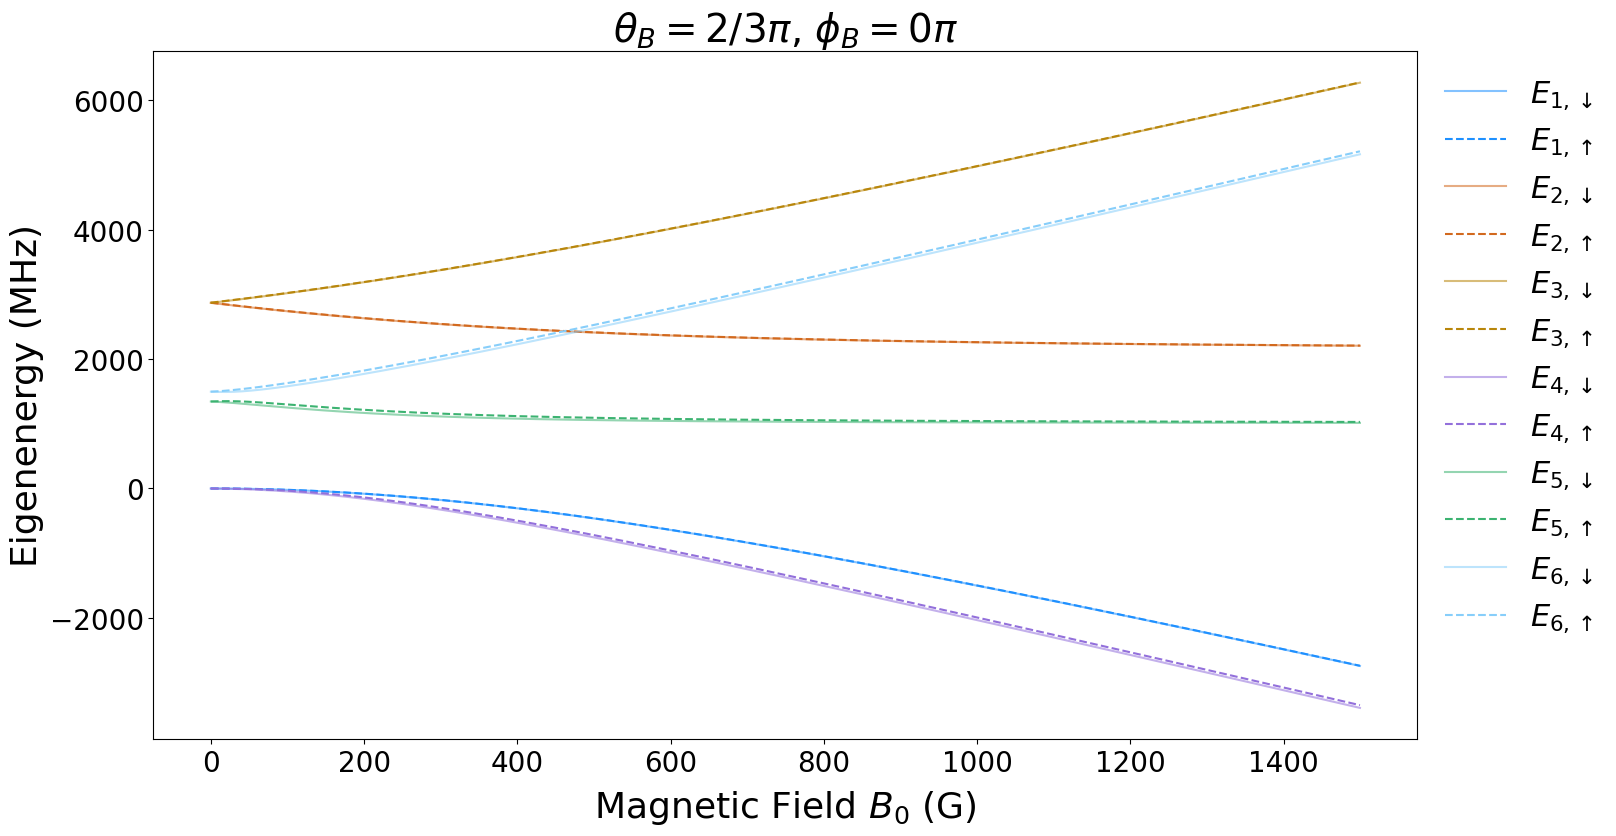

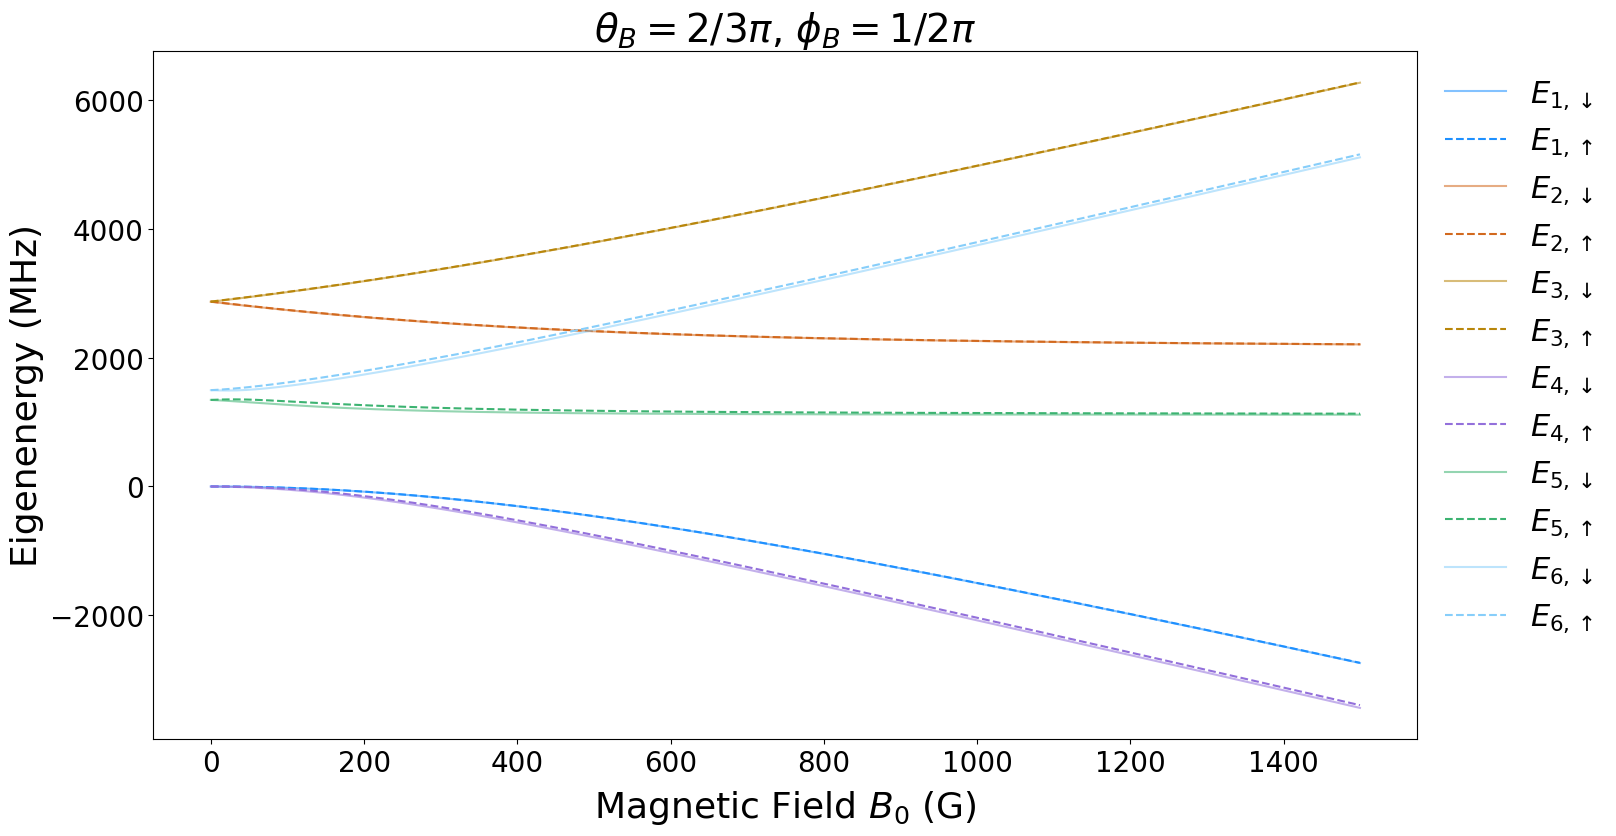

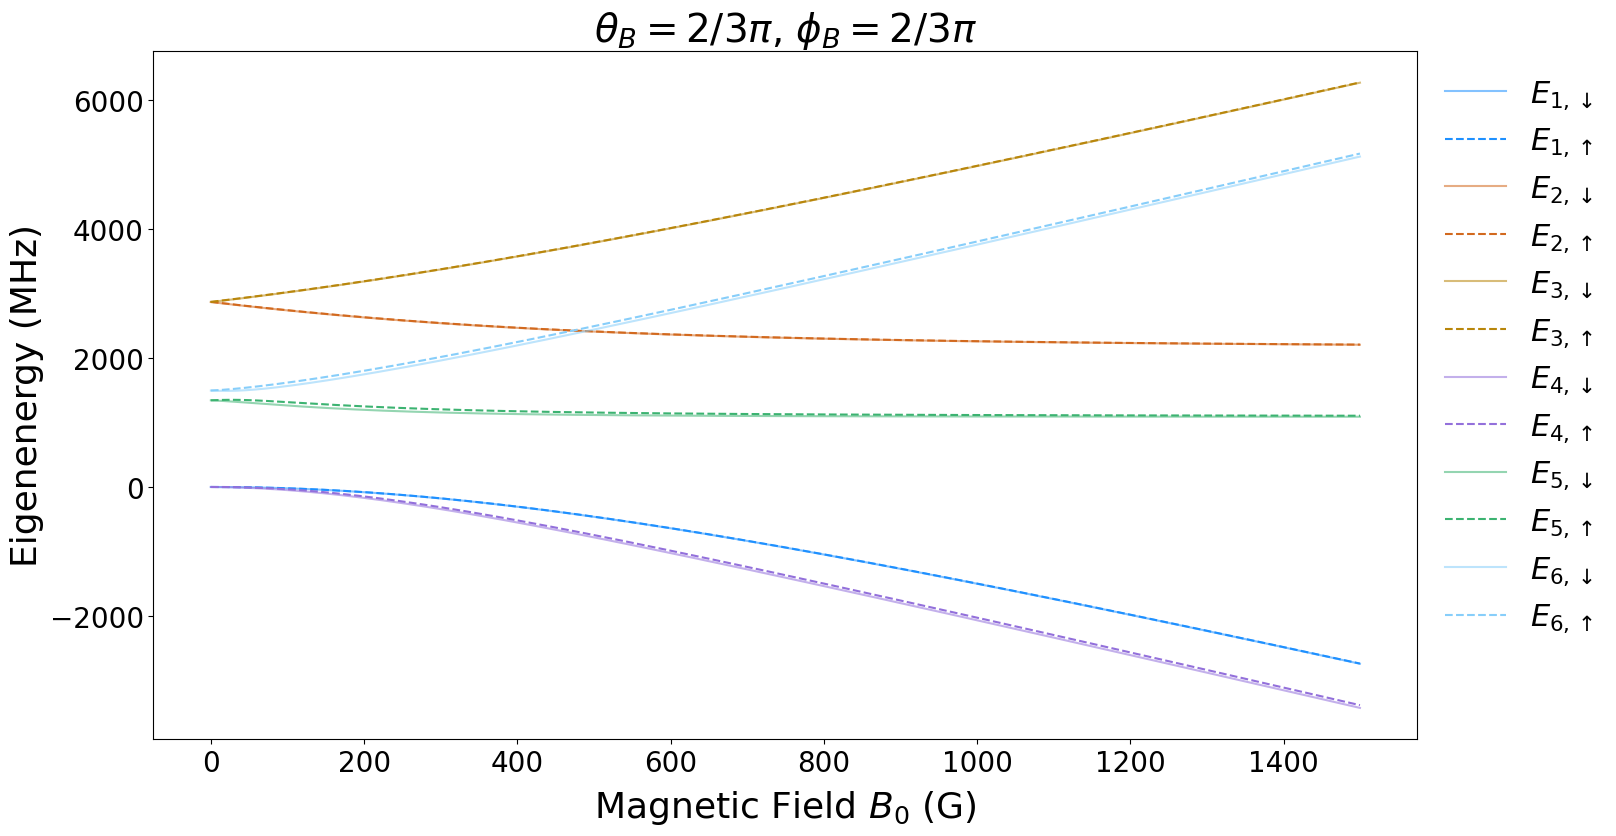

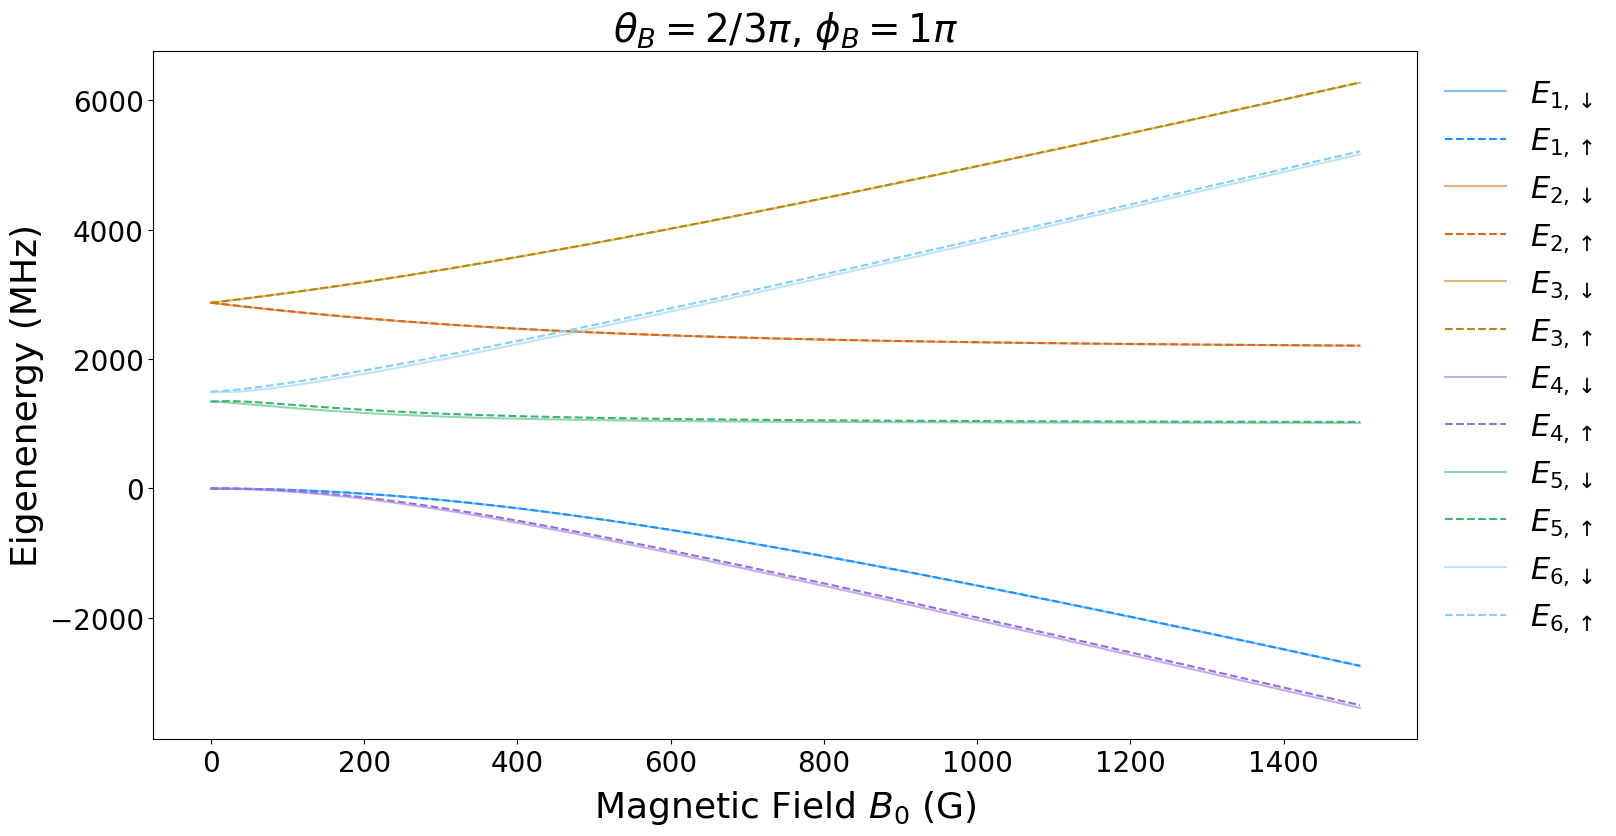

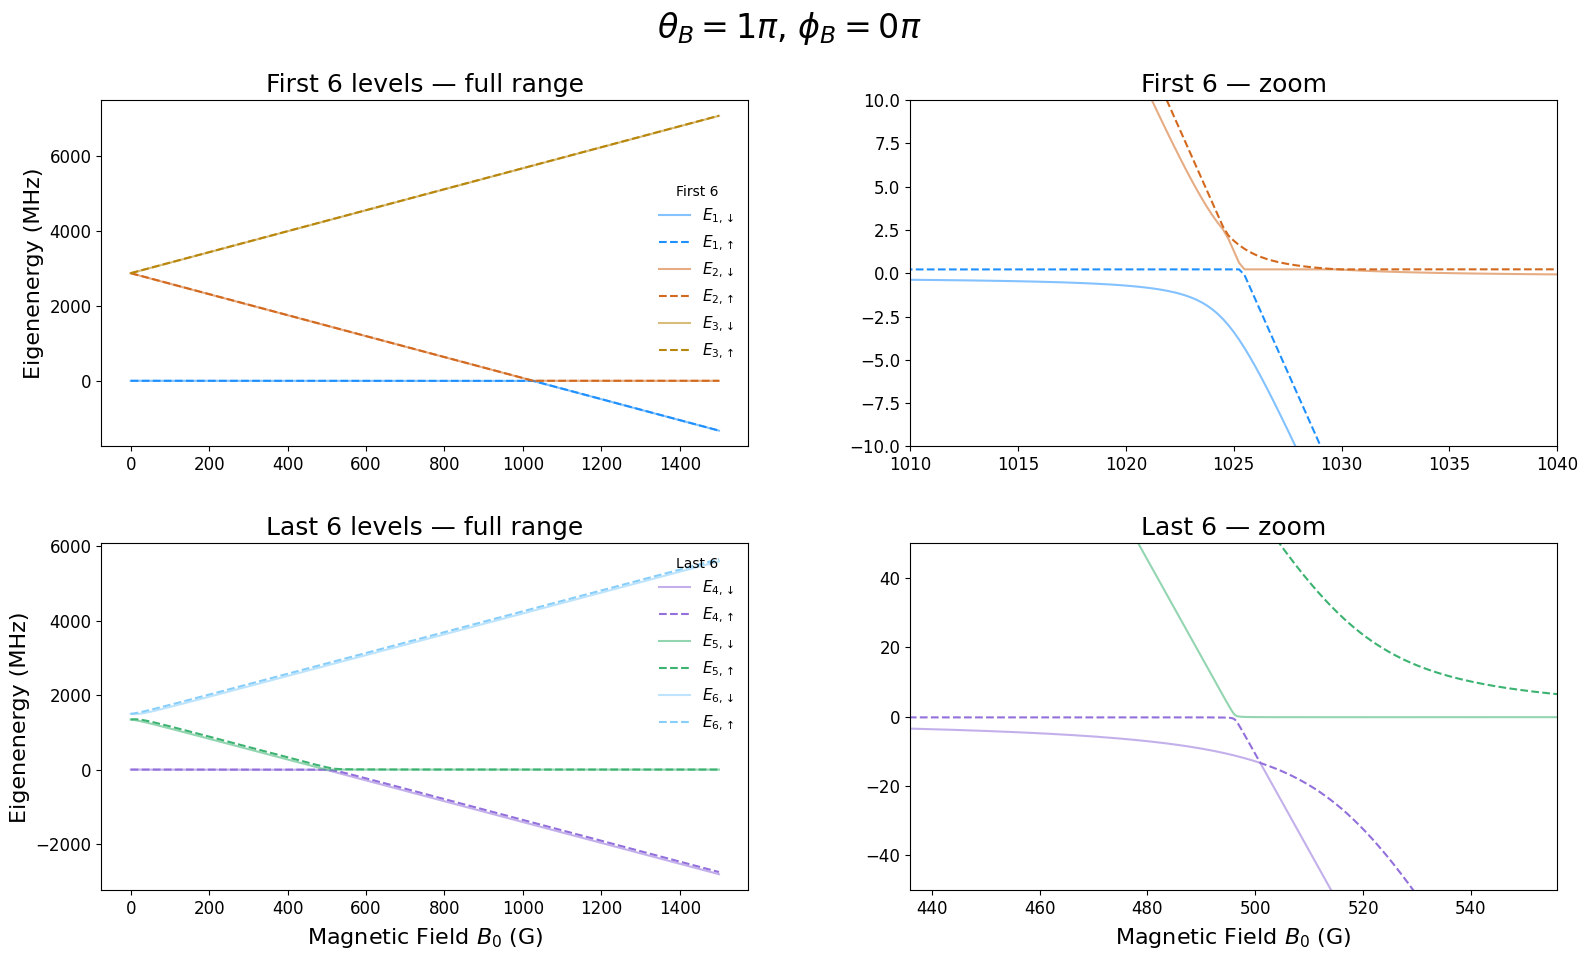

In [8]:
import os
import re

# ------------------------ labels / colors ------------------------
labels = [
    r"$E_{1,\downarrow}$", r"$E_{1,\uparrow}$",
    r"$E_{2,\downarrow}$", r"$E_{2,\uparrow}$",
    r"$E_{3,\downarrow}$", r"$E_{3,\uparrow}$",
    r"$E_{4,\downarrow}$", r"$E_{4,\uparrow}$",
    r"$E_{5,\downarrow}$", r"$E_{5,\uparrow}$",
    r"$E_{6,\downarrow}$", r"$E_{6,\uparrow}$",
]
# Pairs share a color; ↑ is dashed. (We only use the first 6 entries.)
e_colors = [
    "dodgerblue", "chocolate", "darkgoldenrod",
    "mediumpurple", "mediumseagreen", "lightskyblue", "magenta"
]

# ---------- table rows at the SAME B values ----------
annotate_at_B = sorted(set([0, 100, 350, 475, 508, 525, 750, 1000, 1025, 1050, 1200]))

# ---------- BASIS LABELS (match to your *internal* basis order) ----------
user_labels_gs6 = [
    r"|1,\downarrow\rangle", r"|1,\uparrow\rangle",
    r"|2,\downarrow\rangle", r"|2,\uparrow\rangle",
    r"|3,\downarrow\rangle", r"|3,\uparrow\rangle",
]
internal_to_user_gs6 = [0, 1, 4, 5, 2, 3]
basis_gs6 = [user_labels_gs6[i] for i in internal_to_user_gs6]

user_labels_es6 = [
    r"|4,\downarrow\rangle", r"|4,\uparrow\rangle",
    r"|5,\downarrow\rangle", r"|5,\uparrow\rangle",
    r"|6,\downarrow\rangle", r"|6,\uparrow\rangle",
]
internal_to_user_es6 = [0, 1, 4, 5, 2, 3]
basis_es6 = [user_labels_es6[i] for i in internal_to_user_es6]

# ---------- horizontal zoom controls (Gauss) ----------
B_focus_gs = 2870/mu_e
r_gs       = 15
B_focus_es = 496  # convert MHz to G
r_es       = 60

# ---------- NEW: vertical zoom controls (MHz) ----------
# If Y_focus_* is None, no y-zoom is applied.
Y_focus_gs = 0.0   # e.g. 2870.0
Ry_gs      = 10.0
Y_focus_es = 0.0   # e.g. 1500.0
Ry_es      = 50.0

# ---------- helpers ----------
def nearest_idx(xarr, x):
    return int(np.abs(xarr - x).argmin())

def superposition_label(vec_qobj, basis_labels, kmax=6, prob_thresh=0.005, gap=0.15,
                        decimals=3, terms_per_line=2):
    """
    Return (cell_text, n_lines); each line is its own $...$.
    If a coefficient would print as '1.00' (with given 'decimals'), omit it and show only the state.
    """
    v = np.array(vec_qobj.full()).ravel()
    if v.size == 0:
        core_lines = [basis_labels[0]]
    else:
        # fix global phase (largest component real-positive)
        top = np.argmax(np.abs(v))
        ang0 = np.angle(v[top]) if np.abs(v[top]) > 0 else 0.0
        v = v * np.exp(-1j * ang0)

        probs = np.abs(v) ** 2
        order = np.argsort(probs)[::-1]
        pmax = probs[order[0]]

        sel = [i for i in order if (probs[i] >= prob_thresh) or (probs[i] >= pmax - gap)]
        sel = sel[:kmax] if len(sel) > kmax else sel
        if not sel:
            sel = [order[0]]

        def fmt_term(i):
            amp = np.abs(v[i])
            s = f"{amp:.{decimals}f}"
            if s == f"{1.0:.{decimals}f}":
                return f"{basis_labels[i]}"
            return f"{s}{basis_labels[i]}"

        terms = [fmt_term(i) for i in sel]
        core_lines = []
        for s in range(0, len(terms), terms_per_line):
            chunk = terms[s:s+terms_per_line]
            if s > 0 and not chunk[0].startswith("-"):
                chunk[0] = "+" + chunk[0]
            core_lines.append("+".join(chunk).replace("+-", "-"))

    fmt = r"${line}$"
    lines = [fmt.format(line=L) for L in core_lines]
    return "\n".join(lines), len(lines)

# ---------- LaTeX table writer (ABNTEX-style float; no preamble) ----------
def save_table_as_tex(filepath, col_labels, rows, caption, label):
    """
    Writes an ABNTEX-style table float. Use \\input{...} in your main doc.
    Cells are assumed to be TeX-ready (may contain \\shortstack and \\).
    Your preamble must include: \\usepackage{physics} (for \\ket{}).
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    num_levels = len(col_labels) - 1

    header_cells = [r"\textbf{B}"] + [rf"{c}" for c in col_labels[1:]]
    header_line  = " & ".join(header_cells) + r" \\"

    body_lines = []
    for r in rows:
        bval  = r[0]
        cells = [bval] + r[1:]  # already formatted
        body_lines.append("    " + " & ".join(cells) + r" \\")
    body_block = "\n\\hline\n".join(body_lines)  # fixed invalid escape

    col_spec = "l|" + "c"*num_levels

    tex = rf"""% Requires in preamble: \usepackage{{physics}}
\begin{{table}}[hbt]
  \ABNTEXfontereduzida
  \caption{{{caption}}}
  \label{{{label}}}
  \centering
  \begin{{tabular}}{{{col_spec}}}
    \hline
    {header_line}
    \hline
{body_block}
    \hline
  \end{{tabular}}
  \begin{{flushleft}}
    Source: By the author
  \end{{flushleft}}
\end{{table}}
"""
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(tex)

# ---------------------------------------------------------------
# MAIN: sweep, compute spectra, plot + write LaTeX table
# ---------------------------------------------------------------
init_b = 0
B_END = 1500
os.makedirs("Figs", exist_ok=True)
os.makedirs("Tables", exist_ok=True)

thetas = [0.0, np.pi/2, 2*np.pi/3, np.pi]
phis   = [0.0, np.pi/2, 2*np.pi/3, np.pi]

for thetab in thetas:
    for phib in phis:

        # ---- sweep field (energies only: fast pass) ----
        B_values = np.arange(init_b, B_END, 0.25)
        nB = len(B_values)

        energies_gs = np.empty((nB, 6))
        energies_es = np.empty((nB, 6))

        for k, i in enumerate(B_values):
            bs = B0(i, phib, thetab)
            H  = H_doh_hf(bs, 0.0)[0] + H_doh_hf(bs, 0.0)[1]   # full 12×12
            H_full = H.full()

            h_gs = qt.Qobj(H_full[:6,  :6])        # first 6
            h_es = qt.Qobj(H_full[6:12, 6:12])     # last 6

            energies_gs[k] = h_gs.eigenenergies()
            energies_es[k] = h_es.eigenenergies()

        # ---- indices for table rows ----
        k_list = [nearest_idx(B_values, x) for x in annotate_at_B
                  if (B_values.min() <= x <= B_values.max())]
        k_list = sorted(set(k_list))

        # ---- compute eigenstates only at table rows ----
        rows = []
        num_levels = 12

        # Two-line headers: E_{i,↓} over E_{i,↑}
        pair_headers = []
        for i_pair in range(6):
            hd = labels[2*i_pair]     # down
            hu = labels[2*i_pair+1]   # up
            pair_headers.append(rf"\shortstack{{\textbf{{{hd}}} \\ \textbf{{{hu}}}}}")
        col_labels = ["B"] + pair_headers

        # helper to make \ket{} and preserve newlines as \\ inside stacks
        def to_ket_and_preserve(s: str) -> str:
            s = re.sub(r"\|(.*?)\\rangle", r"\\ket{\1}", s)
            return s.replace("\n", r"\\")

        for k in k_list:
            iB = B_values[k]
            bs = B0(iB, phib, thetab)
            H  = H_doh_hf(bs, 0.0)[0] + H_doh_hf(bs, 0.0)[1]   # full 12×12
            H_full = H.full()

            h_gs = qt.Qobj(H_full[:6,  :6])
            h_es = qt.Qobj(H_full[6:12, 6:12])
            _, evecs_g = h_gs.eigenstates()
            _, evecs_e = h_es.eigenstates()

            # 12 state strings (may be multi-line)
            state_strs = []
            for j in range(num_levels):
                vec = evecs_g[j] if j < 6 else evecs_e[j-6]
                txt, _ = superposition_label(
                    vec,
                    basis_gs6 if j < 6 else basis_es6,
                    kmax=6, prob_thresh=0.005, gap=0.15, decimals=3,
                    terms_per_line=2
                )
                state_strs.append(to_ket_and_preserve(txt))

            # collapse to 6 columns: \shortstack of (down \\ up)
            pair_cells = []
            for i_pair in range(6):
                down_tex = state_strs[2*i_pair]
                up_tex   = state_strs[2*i_pair+1]
                pair_cells.append(rf"\shortstack[c]{{{down_tex} \\ {up_tex}}}")

            rows.append([str(iB)] + pair_cells)

        # ---------- PLOTTING ----------
        theta_frac = Fraction(thetab/np.pi).limit_denominator()
        phi_frac   = Fraction(phib/np.pi).limit_denominator()
        special_layout = (np.isclose(thetab, 0.0) or np.isclose(thetab, np.pi)) and np.isclose(phib, 0.0)

        if special_layout:
            # 2×2 grid: first 6 (top), last 6 (bottom); left=full, right=zoom
            # NOTE: no sharey so vertical zoom applies only to the zoom panels
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))

            ax_gs_full  = axes[0, 0]
            ax_gs_zoom  = axes[0, 1]
            ax_es_full  = axes[1, 0]
            ax_es_zoom  = axes[1, 1]

            # --- top row: first 6 levels (pairs share color; ↑ dashed)
            for j in range(6):
                y = energies_gs[:, j]
                ax_gs_full.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )
                
                ax_gs_zoom.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            # --- bottom row: last 6 levels
            for j in range(6, 12):
                y = energies_es[:, j-6]
                ax_es_full.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],  
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )
                ax_es_zoom.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[j // 2],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            fig.suptitle(f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$", fontsize=24, y=0.99)

            # Titles
            ax_gs_full.set_title("First 6 levels — full range", fontsize=18)
            ax_es_full.set_title("Last 6 levels — full range", fontsize=18)
            ax_gs_zoom.set_title(
                rf"First 6 — zoom",# @ ${B_focus_gs:.2f}\,\mathrm{{G}}\pm{r_gs}\,\mathrm{{G}}$",
                fontsize=18
            )
            ax_es_zoom.set_title(
                rf"Last 6 — zoom",# @ ${B_focus_es:.2f}\,\mathrm{{G}}\pm{r_es}\,\mathrm{{G}}$",
                fontsize=18
            )

            # Labels
            ax_gs_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_ylabel('Eigenenergy (MHz)', fontsize=16)
            ax_es_full.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)
            ax_es_zoom.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=16, labelpad=6)

            # Horizontal zoom windows (symmetric)
            ax_gs_zoom.set_xlim(B_focus_gs - r_gs, B_focus_gs + r_gs)
            ax_es_zoom.set_xlim(B_focus_es - r_es, B_focus_es + r_es)

            # Vertical zoom windows (if specified)
            if Y_focus_gs is not None:
                ax_gs_zoom.set_ylim(Y_focus_gs - Ry_gs, Y_focus_gs + Ry_gs)
            if Y_focus_es is not None:
                ax_es_zoom.set_ylim(Y_focus_es - Ry_es, Y_focus_es + Ry_es)

            # Ticks/legends
            for ax in (ax_gs_full, ax_gs_zoom, ax_es_full, ax_es_zoom):
                ax.tick_params(labelsize=12)
            ax_gs_full.legend(loc="best", fontsize=11, frameon=False, title="First 6")
            ax_es_full.legend(loc="best", fontsize=11, frameon=False, title="Last 6")

            fig.subplots_adjust(top=0.90, wspace=0.25, hspace=0.28, left=0.07, right=0.98)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_M3_GRID_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        else:
            # Original single-axes plot for all other angles
            fig = plt.figure(figsize=(16, 8.0))
            ax  = fig.add_subplot(111)

            for j in range(num_levels):
                y = energies_gs[:, j] if j < 6 else energies_es[:, j-6]
                ax.plot(
                    B_values, y,
                    ls='--' if (j % 2 == 1) else '-',
                    label=labels[j],
                    color=e_colors[(j // 2) if j < 12 else -1],
                    alpha=1.0 if (j % 2 == 1) else 0.55
                )

            ax.set_title(
                f"$\\theta_B={theta_frac}\\pi$, $\\phi_B={phi_frac}\\pi$",
                fontsize=28
            )
            ax.set_xlabel('Magnetic Field $B_0$ (G)', fontsize=26, labelpad=8)
            ax.set_ylabel('Eigenenergy (MHz)', fontsize=26)
            ax.tick_params(labelsize=20)
            fig.subplots_adjust(left=0.07, right=0.86, top=0.96, bottom=0.10)
            ax.legend(bbox_to_anchor=(1.00, 1.00), loc="upper left", fontsize=22, frameon=False)

            # ---- save plot ----
            plt.savefig(
                f'Figs/energy_levels_M3_no_table_t-{int(100*thetab)}_p-{int(100*phib)}.png',
                bbox_inches='tight', dpi=300
            )
            plt.show()

        # ---- save LaTeX table (ABNTEX-style, 6 columns with stacked ↑/↓) ----
        tex_path   = f'Tables/energy_levels_M3_table_t-{int(100*thetab)}_p-{int(100*phib)}.tex'
        caption    = rf"Eigenstate compositions at $\theta_B={theta_frac}\pi$, $\phi_B={phi_frac}\pi$."
        label_tex  = rf"tab:energy_levels_M3_t-{int(100*thetab)}_p-{int(100*phib)}"

        save_table_as_tex(tex_path, col_labels, rows, caption, label_tex)

        # keep only the first phi when theta is 0 or pi (=> only (0,0) and (π,0))
        if np.isclose(thetab, 0) or np.isclose(thetab, np.pi):
            break

plt.close('all')